In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('gorimost.csv')
data

,Год,Территория,Поголовье скота,Т. год,Осадки. год,Горимость
0,2001,Актюбинская область,3183.3,5.700000,402.00,0.09
1,2002,Актюбинская область,3284.7,5.700000,308.00,0.17
2,2003,Актюбинская область,3468.8,5.000000,381.00,0.06
3,2004,Актюбинская область,3657.4,6.500000,406.00,0.19
4,2005,Актюбинская область,3878.1,5.700000,220.00,0.07
...,...,...,...,...,...,...
115,2016,Калмыкия,5306.1,11.617099,285.75,0.00
116,2017,Калмыкия,5691.1,11.898593,191.90,0.02
117,2018,Калмыкия,5090.6,11.781667,186.20,0.01
118,2019,Калмыкия,NaN,12.235244,208.20,0.01


In [3]:
data = data.drop(['Год'], axis=1)
data['Поголовье скота'] = data.groupby(['Территория'])['Поголовье скота'].transform(lambda x: x.fillna(x.mean())).round(0)
data['Т. год'] = data.groupby(['Территория'])['Т. год'].transform(lambda x: x.fillna(x.mean())).round(0)
data['Осадки. год'] = data.groupby(['Территория'])['Осадки. год'].transform(lambda x: x.fillna(x.mean())).round(0)

In [4]:
enc = OneHotEncoder()
data = data.drop(['Территория'], axis = 1).join(enc.fit_transform(data[['Территория']], axis = 0))

<AxesSubplot:>

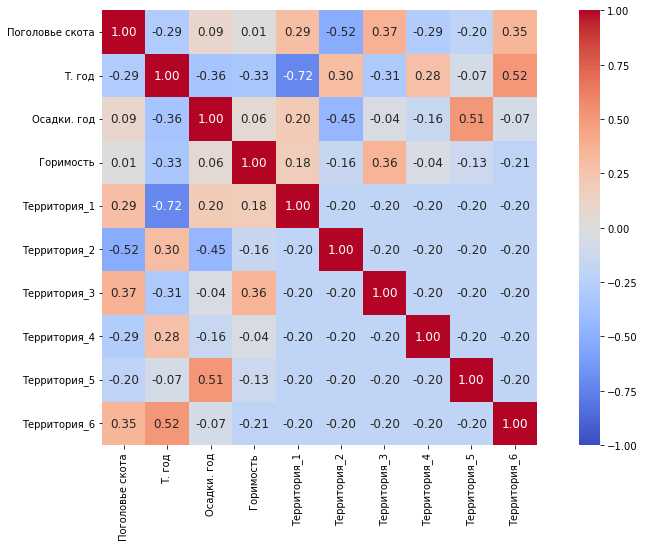

In [5]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, vmin=-1, center=0,\
                        cmap=sns.color_palette('coolwarm',1000))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Горимость'], axis=1), 
                                                    data['Горимость'], test_size=0.15, 
                                                    random_state=1231)

In [7]:
cv = 10
scalers = (RobustScaler(), StandardScaler(), MinMaxScaler())

regressors = (
    RidgeCV(cv=cv, alphas=[0.001,0.01, 0.1, 1, 10]), 
    LassoCV(cv=cv, alphas=[0.001,0.01, 0.1, 1, 10], n_alphas=[100, 200, 300, 400]), 
    ElasticNetCV(cv=cv, alphas=[0.001,0.01, 0.1, 1, 10], n_alphas=[100, 200, 300, 400])
)

for scaler in scalers:
    for regressor in regressors:
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        print('R2: ' + str(regressor.score(X_test, y_test)))
        print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))
        print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
        print('Scaler: ' + scaler.__class__.__name__)
        print('Regressor\'s type:' + regressor.__class__.__name__)
        print('==' * 20)

R2: 0.20219469125955603
RMSE: 0.035868986303590554
MAE: 0.0260354215346333
Scaler: RobustScaler
Regressor's type:RidgeCV
R2: 0.177034671089232
RMSE: 0.03643018794476603
MAE: 0.02550083686037457
Scaler: RobustScaler
Regressor's type:LassoCV
R2: 0.1586649717960461
RMSE: 0.036834529569839444
MAE: 0.02668829886940705
Scaler: RobustScaler
Regressor's type:ElasticNetCV
R2: 0.18264230240497192
RMSE: 0.03630585934555389
MAE: 0.026209261038467418
Scaler: StandardScaler
Regressor's type:RidgeCV
R2: 0.16175210651191974
RMSE: 0.03676688846628651
MAE: 0.027015052972378516
Scaler: StandardScaler
Regressor's type:LassoCV
R2: 0.14866834040518873
RMSE: 0.03705271487272105
MAE: 0.027436181850070056
Scaler: StandardScaler
Regressor's type:ElasticNetCV
R2: 0.19365492921549943
RMSE: 0.03606044734342214
MAE: 0.028231342021188766
Scaler: MinMaxScaler
Regressor's type:RidgeCV
R2: 0.21896160913650053
RMSE: 0.03549006813015815
MAE: 0.026426989059261885
Scaler: MinMaxScaler
Regressor's type:LassoCV
R2: 0.1952084

In [8]:
df = pd.read_csv('Statistika_gorimost_po_rayonam - Динамика горимости.csv')

list_of_df = []
for i in range(len(df)):
    new_df = df.iloc[i,:].to_frame(name="flammability").reset_index()
    new_df['region'] = new_df.iloc[1,1]
    new_df['OSM_ID'] = new_df.iloc[0,1]
    new_df = new_df.iloc[3:,:]
    list_of_df.append(new_df)
    
output1 = pd.concat(list_of_df).reset_index()
output1 = output1.rename(columns={"index": "year"})
output1 = output1.drop(['level_0'], axis=1)

In [9]:
df = pd.read_csv('Statistika_gorimost_po_rayonam - Динамика NDVI.csv')

list_of_df = []
for i in range(len(df)):
    new_df = df.iloc[i,:].to_frame(name="NDVI").reset_index()
    new_df['OSM_ID'] = new_df.iloc[0,1]
    new_df = new_df.iloc[1:,:]
    list_of_df.append(new_df)
    
output2 = pd.concat(list_of_df).reset_index()
output2 = output2.rename(columns={"index": "year"})
output2 = output2.drop(['level_0'], axis=1)

In [10]:
df = pd.read_csv('Statistika_gorimost_po_rayonam - Динамика Осадки.csv')

list_of_df = []
for i in range(len(df)):
    new_df = df.iloc[i,:].to_frame(name="precipitation").reset_index()
    new_df['OSM_ID'] = new_df.iloc[0,1]
    new_df = new_df.iloc[1:,:]
    list_of_df.append(new_df)
    
output3 = pd.concat(list_of_df).reset_index()
output3 = output3.rename(columns={"index": "year"})
output3 = output3.drop(['level_0'], axis=1)

In [11]:
df = pd.read_csv('Statistika_gorimost_po_rayonam - Динамика Скот.csv')

list_of_df = []
for i in range(len(df)):
    new_df = df.iloc[i,:].to_frame(name="stock").reset_index()
    new_df['OSM_ID'] = new_df.iloc[0,1]
    new_df = new_df.iloc[1:,:]
    list_of_df.append(new_df)
    
output4 = pd.concat(list_of_df).reset_index()
output4 = output4.rename(columns={"index": "year"})
output4 = output4.drop(['level_0'], axis=1)

In [12]:
df = pd.read_csv('Statistika_gorimost_po_rayonam - Динамика Т макс.csv')

list_of_df = []
for i in range(len(df)):
    new_df = df.iloc[i,:].to_frame(name="t").reset_index()
    new_df['OSM_ID'] = new_df.iloc[0,1]
    new_df = new_df.iloc[1:,:]
    list_of_df.append(new_df)
    
output5 = pd.concat(list_of_df).reset_index()
output5 = output5.rename(columns={"index": "year"})
output5 = output5.drop(['level_0'], axis=1)

In [13]:
df = output1.merge(output2, on=['OSM_ID','year'])
df = df.merge(output3, on=['OSM_ID','year'])
df = df.merge(output4, on=['OSM_ID','year'])
df = df.merge(output5, on=['OSM_ID','year'])
df.to_csv('out.csv', index=False)
df = df.fillna(-9999)
df = df.drop(['OSM_ID', 'year'], axis=1)

df = df.replace(to_replace=r',', value='.', regex=True)

df = df.astype({'flammability':'float64', 'stock':'float64','t':'float64', 'NDVI':'float64', 'precipitation':'float64'})
df['flammability'] = df['flammability'] + 0.0001
df

,flammability,region,NDVI,precipitation,stock,t
0,28.6201,Ахтубинский район,3443.553826,305.300003,-9999.0,22.864286
1,15.9401,Ахтубинский район,3283.658314,327.975006,-9999.0,22.464286
2,0.6601,Ахтубинский район,2986.687553,318.075005,-9999.0,20.989285
3,2.5201,Ахтубинский район,3269.350491,319.725006,-9999.0,22.935715
4,11.4601,Ахтубинский район,3305.540993,312.275009,-9999.0,22.800001
...,...,...,...,...,...,...
1155,0.0001,Уральск Г.А.,5255.108136,503.277455,4.2,22.314868
1156,1.2501,Уральск Г.А.,4987.325018,350.355044,4.4,20.957724
1157,4.8001,Уральск Г.А.,4460.976181,281.203069,4.0,21.128864
1158,0.0001,Уральск Г.А.,4650.686799,325.610196,4.4,21.443149


In [14]:
enc = OneHotEncoder()
df = df.drop(['region'], axis = 1).join(enc.fit_transform(df[['region']], axis = 0))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['flammability'], axis=1), 
                                                    df['flammability'], test_size=0.20, 
                                                    random_state=42)

In [16]:
cv = 10
scalers = (RobustScaler(), StandardScaler(), MinMaxScaler())

regressors = (
    RidgeCV(cv=cv, alphas=[0.001,0.01, 0.1, 1, 10]), 
    LassoCV(cv=cv, alphas=[0.001,0.01, 0.1, 1, 10], n_alphas=[100, 200, 300, 400]), 
    ElasticNetCV(cv=cv, alphas=[0.001,0.01, 0.1, 1, 10], n_alphas=[100, 200, 300, 400])
)

for scaler in scalers:
    for regressor in regressors:
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        print('R2: ' + str(regressor.score(X_test, y_test)))
        print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))
        print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
        print('Scaler: ' + scaler.__class__.__name__)
        print('Regressor\'s type:' + regressor.__class__.__name__)
        print('==' * 20)

R2: 0.3050641042409641
RMSE: 4.762710786797103
MAE: 3.0262433724370217
Scaler: RobustScaler
Regressor's type:RidgeCV
R2: 0.28886457097757245
RMSE: 4.817902372525544
MAE: 3.1200044948673176
Scaler: RobustScaler
Regressor's type:LassoCV
R2: 0.2981896985537924
RMSE: 4.786209526141108
MAE: 3.061820785558631
Scaler: RobustScaler
Regressor's type:ElasticNetCV
R2: 0.29283685536769455
RMSE: 4.804427527903161
MAE: 3.079838377083696
Scaler: StandardScaler
Regressor's type:RidgeCV
R2: 0.28985225949558857
RMSE: 4.814555443026448
MAE: 3.0991802752965976
Scaler: StandardScaler
Regressor's type:LassoCV
R2: 0.2916166535640129
RMSE: 4.8085707333966505
MAE: 3.0907474412305604
Scaler: StandardScaler
Regressor's type:ElasticNetCV
R2: 0.30360445890370036
RMSE: 4.767709968759495
MAE: 3.0037057509214353
Scaler: MinMaxScaler
Regressor's type:RidgeCV
R2: 0.2892962207239299
RMSE: 4.816439949246223
MAE: 3.1132319114009914
Scaler: MinMaxScaler
Regressor's type:LassoCV
R2: 0.2981707800290303
RMSE: 4.78627403603291

D:\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.9628194387951226, tolerance: 3.652559387952096
  model = cd_fast.enet_coordinate_descent_gram(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3440971119343885, tolerance: 3.7501442370693785
  model = cd_fast.enet_coordinate_descent_gram(


In [26]:
from catboost import CatBoostRegressor, Pool

model = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=2)
train_dataset = Pool(X_train, y_train) 
test_dataset = Pool(X_test, y_test)
model = CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1, 0.2],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset);

0:	learn: 7.8109010	test: 5.8847757	best: 5.8847757 (0)	total: 313us	remaining: 31ms
1:	learn: 7.7419760	test: 5.8068524	best: 5.8068524 (1)	total: 762us	remaining: 37.4ms
2:	learn: 7.6781621	test: 5.7483205	best: 5.7483205 (2)	total: 1.1ms	remaining: 35.7ms
3:	learn: 7.6225895	test: 5.6987466	best: 5.6987466 (3)	total: 1.5ms	remaining: 35.9ms
4:	learn: 7.5662902	test: 5.6484695	best: 5.6484695 (4)	total: 1.9ms	remaining: 36ms
5:	learn: 7.5125645	test: 5.6038073	best: 5.6038073 (5)	total: 2.29ms	remaining: 35.8ms
6:	learn: 7.4658681	test: 5.5640303	best: 5.5640303 (6)	total: 2.67ms	remaining: 35.6ms
7:	learn: 7.4206413	test: 5.5247058	best: 5.5247058 (7)	total: 3.07ms	remaining: 35.3ms
8:	learn: 7.3739396	test: 5.4863598	best: 5.4863598 (8)	total: 4.01ms	remaining: 40.6ms
9:	learn: 7.3246102	test: 5.4455028	best: 5.4455028 (9)	total: 4.35ms	remaining: 39.1ms
10:	learn: 7.2853264	test: 5.4121034	best: 5.4121034 (10)	total: 4.7ms	remaining: 38.1ms
11:	learn: 7.2480096	test: 5.3799441	bes

71:	learn: 5.4228178	test: 4.5644008	best: 4.5627649 (70)	total: 24.8ms	remaining: 9.63ms
72:	learn: 5.4066395	test: 4.5649679	best: 4.5627649 (70)	total: 25.2ms	remaining: 9.31ms
73:	learn: 5.3917864	test: 4.5638085	best: 4.5627649 (70)	total: 26.8ms	remaining: 9.43ms
74:	learn: 5.3760284	test: 4.5816848	best: 4.5627649 (70)	total: 27.3ms	remaining: 9.09ms
75:	learn: 5.3620984	test: 4.5563437	best: 4.5563437 (75)	total: 27.8ms	remaining: 8.79ms
76:	learn: 5.3516742	test: 4.5584702	best: 4.5563437 (75)	total: 28.2ms	remaining: 8.43ms
77:	learn: 5.3427270	test: 4.5480910	best: 4.5480910 (77)	total: 28.5ms	remaining: 8.04ms
78:	learn: 5.3307438	test: 4.5476249	best: 4.5476249 (78)	total: 28.8ms	remaining: 7.67ms
79:	learn: 5.3139099	test: 4.5391800	best: 4.5391800 (79)	total: 29.2ms	remaining: 7.29ms
80:	learn: 5.3005500	test: 4.5568345	best: 4.5391800 (79)	total: 29.5ms	remaining: 6.93ms
81:	learn: 5.2909929	test: 4.5648356	best: 4.5391800 (79)	total: 30ms	remaining: 6.58ms
82:	learn: 5

54:	learn: 6.4619167	test: 4.8582080	best: 4.8582080 (54)	total: 17.9ms	remaining: 14.6ms
55:	learn: 6.4538784	test: 4.8557387	best: 4.8557387 (55)	total: 18.3ms	remaining: 14.4ms
56:	learn: 6.4434325	test: 4.8533379	best: 4.8533379 (56)	total: 18.6ms	remaining: 14ms
57:	learn: 6.4347916	test: 4.8531749	best: 4.8531749 (57)	total: 18.9ms	remaining: 13.7ms
58:	learn: 6.4265549	test: 4.8407690	best: 4.8407690 (58)	total: 19.3ms	remaining: 13.4ms
59:	learn: 6.4194111	test: 4.8314869	best: 4.8314869 (59)	total: 19.7ms	remaining: 13.1ms
60:	learn: 6.4102693	test: 4.8267336	best: 4.8267336 (60)	total: 20.1ms	remaining: 12.8ms
61:	learn: 6.4031305	test: 4.8279457	best: 4.8267336 (60)	total: 20.4ms	remaining: 12.5ms
62:	learn: 6.3925097	test: 4.8256672	best: 4.8256672 (62)	total: 20.7ms	remaining: 12.1ms
63:	learn: 6.3851455	test: 4.8265120	best: 4.8256672 (62)	total: 21ms	remaining: 11.8ms
64:	learn: 6.3773016	test: 4.8151488	best: 4.8151488 (64)	total: 21.3ms	remaining: 11.5ms
65:	learn: 6.3

114:	learn: 4.9106245	test: 4.6235954	best: 4.5688185 (90)	total: 36.7ms	remaining: 11.2ms
115:	learn: 4.9017484	test: 4.6241670	best: 4.5688185 (90)	total: 37.1ms	remaining: 10.9ms
116:	learn: 4.8944169	test: 4.6211181	best: 4.5688185 (90)	total: 37.3ms	remaining: 10.5ms
117:	learn: 4.8889397	test: 4.6148622	best: 4.5688185 (90)	total: 37.7ms	remaining: 10.2ms
118:	learn: 4.8760112	test: 4.6130526	best: 4.5688185 (90)	total: 38ms	remaining: 9.9ms
119:	learn: 4.8683372	test: 4.6307016	best: 4.5688185 (90)	total: 38.4ms	remaining: 9.6ms
120:	learn: 4.8596520	test: 4.6149971	best: 4.5688185 (90)	total: 38.8ms	remaining: 9.3ms
121:	learn: 4.8502495	test: 4.6106381	best: 4.5688185 (90)	total: 39.1ms	remaining: 8.98ms
122:	learn: 4.8426143	test: 4.6140247	best: 4.5688185 (90)	total: 39.5ms	remaining: 8.66ms
123:	learn: 4.8312687	test: 4.6148319	best: 4.5688185 (90)	total: 39.8ms	remaining: 8.35ms
124:	learn: 4.8210872	test: 4.6146201	best: 4.5688185 (90)	total: 40.1ms	remaining: 8.03ms
125:

5:	learn: 6.5761580	test: 4.8977188	best: 4.8977188 (5)	total: 2.35ms	remaining: 56.5ms
6:	learn: 6.4514388	test: 4.8763424	best: 4.8763424 (6)	total: 2.72ms	remaining: 55.5ms
7:	learn: 6.4153692	test: 4.8754120	best: 4.8754120 (7)	total: 2.99ms	remaining: 53ms
8:	learn: 6.3454230	test: 4.7971136	best: 4.7971136 (8)	total: 3.32ms	remaining: 52.1ms
9:	learn: 6.2790940	test: 4.7920472	best: 4.7920472 (9)	total: 3.68ms	remaining: 51.5ms
10:	learn: 6.2312490	test: 4.8066237	best: 4.7920472 (9)	total: 4.14ms	remaining: 52.3ms
11:	learn: 6.2033170	test: 4.7936301	best: 4.7920472 (9)	total: 4.42ms	remaining: 50.8ms
12:	learn: 6.1839355	test: 4.7903852	best: 4.7903852 (12)	total: 4.74ms	remaining: 50ms
13:	learn: 6.1211156	test: 4.7274554	best: 4.7274554 (13)	total: 5.11ms	remaining: 49.6ms
14:	learn: 6.0940351	test: 4.7336435	best: 4.7274554 (13)	total: 5.46ms	remaining: 49.2ms
15:	learn: 6.0525921	test: 4.7093581	best: 4.7093581 (15)	total: 5.84ms	remaining: 48.9ms
16:	learn: 5.9945770	test:

61:	learn: 4.9738616	test: 4.6107840	best: 4.5353313 (49)	total: 20.6ms	remaining: 29.2ms
62:	learn: 4.9611221	test: 4.6283521	best: 4.5353313 (49)	total: 21ms	remaining: 28.9ms
63:	learn: 4.9499250	test: 4.6282425	best: 4.5353313 (49)	total: 21.3ms	remaining: 28.6ms
64:	learn: 4.9272653	test: 4.6292217	best: 4.5353313 (49)	total: 21.7ms	remaining: 28.3ms
65:	learn: 4.9115145	test: 4.6543192	best: 4.5353313 (49)	total: 22ms	remaining: 28ms
66:	learn: 4.8837950	test: 4.6528002	best: 4.5353313 (49)	total: 22.5ms	remaining: 27.9ms
67:	learn: 4.8723921	test: 4.7025051	best: 4.5353313 (49)	total: 22.9ms	remaining: 27.6ms
68:	learn: 4.8577057	test: 4.7161407	best: 4.5353313 (49)	total: 23.2ms	remaining: 27.3ms
69:	learn: 4.8455589	test: 4.7146545	best: 4.5353313 (49)	total: 23.6ms	remaining: 27ms
70:	learn: 4.8322800	test: 4.7252236	best: 4.5353313 (49)	total: 23.9ms	remaining: 26.6ms
71:	learn: 4.8236054	test: 4.7195613	best: 4.5353313 (49)	total: 24.3ms	remaining: 26.3ms
72:	learn: 4.80700

82:	learn: 4.9921685	test: 4.5411822	best: 4.5095675 (67)	total: 26.4ms	remaining: 21.3ms
83:	learn: 4.9831781	test: 4.5244763	best: 4.5095675 (67)	total: 26.8ms	remaining: 21ms
84:	learn: 4.9753279	test: 4.5234043	best: 4.5095675 (67)	total: 27.1ms	remaining: 20.7ms
85:	learn: 4.9645107	test: 4.5253696	best: 4.5095675 (67)	total: 27.4ms	remaining: 20.4ms
86:	learn: 4.9534747	test: 4.5222901	best: 4.5095675 (67)	total: 27.8ms	remaining: 20.1ms
87:	learn: 4.9429794	test: 4.5214733	best: 4.5095675 (67)	total: 28.2ms	remaining: 19.9ms
88:	learn: 4.9354232	test: 4.5190830	best: 4.5095675 (67)	total: 28.6ms	remaining: 19.6ms
89:	learn: 4.9253343	test: 4.5195729	best: 4.5095675 (67)	total: 28.9ms	remaining: 19.3ms
90:	learn: 4.9183166	test: 4.5133721	best: 4.5095675 (67)	total: 29.3ms	remaining: 19ms
91:	learn: 4.9067954	test: 4.4960165	best: 4.4960165 (91)	total: 29.7ms	remaining: 18.7ms
92:	learn: 4.8976275	test: 4.5132335	best: 4.4960165 (91)	total: 30ms	remaining: 18.4ms
93:	learn: 4.885

32:	learn: 5.4342413	test: 4.5955710	best: 4.5757472 (25)	total: 10.8ms	remaining: 54.6ms
33:	learn: 5.3975859	test: 4.5869858	best: 4.5757472 (25)	total: 11.2ms	remaining: 54.6ms
34:	learn: 5.3622248	test: 4.6644692	best: 4.5757472 (25)	total: 11.5ms	remaining: 54.3ms
35:	learn: 5.3448581	test: 4.6573461	best: 4.5757472 (25)	total: 11.9ms	remaining: 54ms
36:	learn: 5.3253429	test: 4.6732811	best: 4.5757472 (25)	total: 12.2ms	remaining: 53.5ms
37:	learn: 5.3009069	test: 4.6289553	best: 4.5757472 (25)	total: 12.5ms	remaining: 53.4ms
38:	learn: 5.2770765	test: 4.6339964	best: 4.5757472 (25)	total: 12.9ms	remaining: 53.2ms
39:	learn: 5.2553997	test: 4.6149380	best: 4.5757472 (25)	total: 13.2ms	remaining: 53ms
40:	learn: 5.2320352	test: 4.6271512	best: 4.5757472 (25)	total: 13.6ms	remaining: 52.7ms
41:	learn: 5.1957047	test: 4.6064935	best: 4.5757472 (25)	total: 13.9ms	remaining: 52.4ms
42:	learn: 5.1694347	test: 4.6164490	best: 4.5757472 (25)	total: 14.4ms	remaining: 52.8ms
43:	learn: 5.1

152:	learn: 4.6775457	test: 4.6117333	best: 4.5238253 (93)	total: 48.6ms	remaining: 14.9ms
153:	learn: 4.6717651	test: 4.6088543	best: 4.5238253 (93)	total: 48.9ms	remaining: 14.6ms
154:	learn: 4.6665229	test: 4.6047843	best: 4.5238253 (93)	total: 49.3ms	remaining: 14.3ms
155:	learn: 4.6610781	test: 4.6201838	best: 4.5238253 (93)	total: 49.6ms	remaining: 14ms
156:	learn: 4.6518812	test: 4.6191006	best: 4.5238253 (93)	total: 50ms	remaining: 13.7ms
157:	learn: 4.6470126	test: 4.6277963	best: 4.5238253 (93)	total: 50.3ms	remaining: 13.4ms
158:	learn: 4.6422136	test: 4.6317957	best: 4.5238253 (93)	total: 50.7ms	remaining: 13.1ms
159:	learn: 4.6371352	test: 4.6326916	best: 4.5238253 (93)	total: 51ms	remaining: 12.8ms
160:	learn: 4.6308765	test: 4.6333798	best: 4.5238253 (93)	total: 51.4ms	remaining: 12.4ms
161:	learn: 4.6246659	test: 4.6238720	best: 4.5238253 (93)	total: 51.8ms	remaining: 12.1ms
162:	learn: 4.6223892	test: 4.6241132	best: 4.5238253 (93)	total: 52.2ms	remaining: 11.8ms
163:	

67:	learn: 5.5776918	test: 4.5878037	best: 4.5878037 (67)	total: 22.1ms	remaining: 42.9ms
68:	learn: 5.5649968	test: 4.5871844	best: 4.5871844 (68)	total: 22.4ms	remaining: 42.6ms
69:	learn: 5.5478024	test: 4.6009613	best: 4.5871844 (68)	total: 22.8ms	remaining: 42.3ms
70:	learn: 5.5373336	test: 4.5847885	best: 4.5847885 (70)	total: 23.1ms	remaining: 42ms
71:	learn: 5.5234681	test: 4.5866918	best: 4.5847885 (70)	total: 23.6ms	remaining: 42ms
72:	learn: 5.5093653	test: 4.5876608	best: 4.5847885 (70)	total: 24.1ms	remaining: 41.9ms
73:	learn: 5.4962283	test: 4.5870375	best: 4.5847885 (70)	total: 24.5ms	remaining: 41.7ms
74:	learn: 5.4818749	test: 4.6021132	best: 4.5847885 (70)	total: 24.8ms	remaining: 41.4ms
75:	learn: 5.4682712	test: 4.5766551	best: 4.5766551 (75)	total: 25.2ms	remaining: 41.1ms
76:	learn: 5.4607182	test: 4.5677696	best: 4.5677696 (76)	total: 25.5ms	remaining: 40.8ms
77:	learn: 5.4483531	test: 4.5830597	best: 4.5677696 (76)	total: 25.9ms	remaining: 40.4ms
78:	learn: 5.4

185:	learn: 5.8754857	test: 4.5817071	best: 4.5817071 (185)	total: 58.2ms	remaining: 4.38ms
186:	learn: 5.8718595	test: 4.5829261	best: 4.5817071 (185)	total: 58.6ms	remaining: 4.07ms
187:	learn: 5.8688877	test: 4.5814959	best: 4.5814959 (187)	total: 59ms	remaining: 3.77ms
188:	learn: 5.8655880	test: 4.5798135	best: 4.5798135 (188)	total: 59.4ms	remaining: 3.46ms
189:	learn: 5.8637914	test: 4.5787102	best: 4.5787102 (189)	total: 59.7ms	remaining: 3.14ms
190:	learn: 5.8607478	test: 4.5780547	best: 4.5780547 (190)	total: 60.1ms	remaining: 2.83ms
191:	learn: 5.8570071	test: 4.5751823	best: 4.5751823 (191)	total: 60.4ms	remaining: 2.52ms
192:	learn: 5.8526903	test: 4.5666844	best: 4.5666844 (192)	total: 60.8ms	remaining: 2.2ms
193:	learn: 5.8495256	test: 4.5650843	best: 4.5650843 (193)	total: 61.1ms	remaining: 1.89ms
194:	learn: 5.8459275	test: 4.5642313	best: 4.5642313 (194)	total: 61.4ms	remaining: 1.57ms
195:	learn: 5.8438966	test: 4.5645815	best: 4.5642313 (194)	total: 61.7ms	remaining

63:	learn: 5.8718307	test: 4.6584771	best: 4.6584771 (63)	total: 34ms	remaining: 19.1ms
64:	learn: 5.8579625	test: 4.6455919	best: 4.6455919 (64)	total: 34.7ms	remaining: 18.7ms
65:	learn: 5.8490432	test: 4.6445871	best: 4.6445871 (65)	total: 35.6ms	remaining: 18.3ms
66:	learn: 5.8257566	test: 4.6416194	best: 4.6416194 (66)	total: 36.3ms	remaining: 17.9ms
67:	learn: 5.8152641	test: 4.6385912	best: 4.6385912 (67)	total: 37.1ms	remaining: 17.5ms
68:	learn: 5.8042752	test: 4.6422676	best: 4.6385912 (67)	total: 37.8ms	remaining: 17ms
69:	learn: 5.7874736	test: 4.6402679	best: 4.6385912 (67)	total: 38.5ms	remaining: 16.5ms
70:	learn: 5.7784596	test: 4.6428867	best: 4.6385912 (67)	total: 39.1ms	remaining: 16ms
71:	learn: 5.7663981	test: 4.6392695	best: 4.6385912 (67)	total: 39.8ms	remaining: 15.5ms
72:	learn: 5.7478617	test: 4.6373725	best: 4.6373725 (72)	total: 40.4ms	remaining: 15ms
73:	learn: 5.7398144	test: 4.6405061	best: 4.6373725 (72)	total: 41.1ms	remaining: 14.4ms
74:	learn: 5.72533

65:	learn: 5.9131510	test: 4.6547066	best: 4.6547066 (65)	total: 39.2ms	remaining: 20.2ms
66:	learn: 5.8913031	test: 4.6515018	best: 4.6515018 (66)	total: 39.9ms	remaining: 19.6ms
67:	learn: 5.8821147	test: 4.6507716	best: 4.6507716 (67)	total: 40.6ms	remaining: 19.1ms
68:	learn: 5.8714897	test: 4.6525296	best: 4.6507716 (67)	total: 41.3ms	remaining: 18.5ms
69:	learn: 5.8553625	test: 4.6505633	best: 4.6505633 (69)	total: 41.8ms	remaining: 17.9ms
70:	learn: 5.8464082	test: 4.6531136	best: 4.6505633 (69)	total: 42.3ms	remaining: 17.3ms
71:	learn: 5.8348688	test: 4.6514975	best: 4.6505633 (69)	total: 42.9ms	remaining: 16.7ms
72:	learn: 5.8168768	test: 4.6493203	best: 4.6493203 (72)	total: 43.4ms	remaining: 16ms
73:	learn: 5.8083245	test: 4.6523681	best: 4.6493203 (72)	total: 43.9ms	remaining: 15.4ms
74:	learn: 5.7936896	test: 4.6435735	best: 4.6435735 (74)	total: 44.4ms	remaining: 14.8ms
75:	learn: 5.7875570	test: 4.6432530	best: 4.6432530 (75)	total: 45.1ms	remaining: 14.2ms
76:	learn: 5

69:	learn: 5.9186943	test: 4.6413738	best: 4.6413738 (69)	total: 39.2ms	remaining: 16.8ms
70:	learn: 5.9098404	test: 4.6436623	best: 4.6413738 (69)	total: 39.9ms	remaining: 16.3ms
71:	learn: 5.8996957	test: 4.6423801	best: 4.6413738 (69)	total: 40.6ms	remaining: 15.8ms
72:	learn: 5.8847549	test: 4.6405237	best: 4.6405237 (72)	total: 41.3ms	remaining: 15.3ms
73:	learn: 5.8784819	test: 4.6409750	best: 4.6405237 (72)	total: 41.8ms	remaining: 14.7ms
74:	learn: 5.8652475	test: 4.6417886	best: 4.6405237 (72)	total: 42.4ms	remaining: 14.1ms
75:	learn: 5.8589178	test: 4.6414520	best: 4.6405237 (72)	total: 43ms	remaining: 13.6ms
76:	learn: 5.8501974	test: 4.6325679	best: 4.6325679 (76)	total: 43.5ms	remaining: 13ms
77:	learn: 5.8414104	test: 4.6299322	best: 4.6299322 (77)	total: 44ms	remaining: 12.4ms
78:	learn: 5.8319623	test: 4.6311117	best: 4.6299322 (77)	total: 44.5ms	remaining: 11.8ms
79:	learn: 5.8189228	test: 4.6199333	best: 4.6199333 (79)	total: 45.1ms	remaining: 11.3ms
80:	learn: 5.811

59:	learn: 6.1983711	test: 4.7281958	best: 4.7281958 (59)	total: 36.7ms	remaining: 24.4ms
60:	learn: 6.1873827	test: 4.7245959	best: 4.7245959 (60)	total: 37.3ms	remaining: 23.8ms
61:	learn: 6.1715571	test: 4.7106042	best: 4.7106042 (61)	total: 37.9ms	remaining: 23.2ms
62:	learn: 6.1613292	test: 4.7076307	best: 4.7076307 (62)	total: 38.4ms	remaining: 22.6ms
63:	learn: 6.1518687	test: 4.7083670	best: 4.7076307 (62)	total: 39ms	remaining: 21.9ms
64:	learn: 6.1364773	test: 4.6976145	best: 4.6976145 (64)	total: 39.5ms	remaining: 21.3ms
65:	learn: 6.1266317	test: 4.6944844	best: 4.6944844 (65)	total: 40.1ms	remaining: 20.6ms
66:	learn: 6.1158076	test: 4.6940028	best: 4.6940028 (66)	total: 40.6ms	remaining: 20ms
67:	learn: 6.1055652	test: 4.6913296	best: 4.6913296 (67)	total: 41.1ms	remaining: 19.3ms
68:	learn: 6.0933706	test: 4.6905944	best: 4.6905944 (68)	total: 41.6ms	remaining: 18.7ms
69:	learn: 6.0816621	test: 4.6885611	best: 4.6885611 (69)	total: 42.1ms	remaining: 18ms
70:	learn: 6.073

49:	learn: 6.0655615	test: 4.7239254	best: 4.7211288 (47)	total: 29.5ms	remaining: 58.9ms
50:	learn: 6.0537383	test: 4.7187031	best: 4.7187031 (50)	total: 30.1ms	remaining: 58.5ms
51:	learn: 6.0382129	test: 4.7169575	best: 4.7169575 (51)	total: 30.7ms	remaining: 57.9ms
52:	learn: 6.0215855	test: 4.7042842	best: 4.7042842 (52)	total: 31.3ms	remaining: 57.3ms
53:	learn: 6.0024099	test: 4.7001666	best: 4.7001666 (53)	total: 31.8ms	remaining: 56.6ms
54:	learn: 5.9903110	test: 4.6916079	best: 4.6916079 (54)	total: 32.4ms	remaining: 55.9ms
55:	learn: 5.9760969	test: 4.6867835	best: 4.6867835 (55)	total: 32.9ms	remaining: 55.2ms
56:	learn: 5.9627658	test: 4.6891165	best: 4.6867835 (55)	total: 33.7ms	remaining: 55ms
57:	learn: 5.9452051	test: 4.6892152	best: 4.6867835 (55)	total: 34.3ms	remaining: 54.4ms
58:	learn: 5.9417384	test: 4.6904348	best: 4.6867835 (55)	total: 34.9ms	remaining: 53.8ms
59:	learn: 5.9312888	test: 4.6862273	best: 4.6862273 (59)	total: 35.5ms	remaining: 53.3ms
60:	learn: 5

28:	learn: 4.8458078	test: 4.3991449	best: 4.3765310 (24)	total: 18.6ms	remaining: 77.7ms
29:	learn: 4.8059455	test: 4.3549970	best: 4.3549970 (29)	total: 19.3ms	remaining: 77.1ms
30:	learn: 4.7700563	test: 4.3805914	best: 4.3549970 (29)	total: 20.1ms	remaining: 77.1ms
31:	learn: 4.7302190	test: 4.3679560	best: 4.3549970 (29)	total: 20.6ms	remaining: 76.1ms
32:	learn: 4.6861958	test: 4.4189636	best: 4.3549970 (29)	total: 21.2ms	remaining: 75ms
33:	learn: 4.6556566	test: 4.4185455	best: 4.3549970 (29)	total: 21.7ms	remaining: 74ms
34:	learn: 4.6226213	test: 4.4249015	best: 4.3549970 (29)	total: 22.2ms	remaining: 73.1ms
35:	learn: 4.5931916	test: 4.4265123	best: 4.3549970 (29)	total: 22.8ms	remaining: 72.1ms
36:	learn: 4.5275023	test: 4.4274338	best: 4.3549970 (29)	total: 23.3ms	remaining: 71.2ms
37:	learn: 4.4921412	test: 4.4549334	best: 4.3549970 (29)	total: 23.8ms	remaining: 70.3ms
38:	learn: 4.4655091	test: 4.4455909	best: 4.3549970 (29)	total: 24.4ms	remaining: 69.4ms
39:	learn: 4.4

35:	learn: 5.3770934	test: 4.5002511	best: 4.5002511 (35)	total: 21.3ms	remaining: 67.3ms
36:	learn: 5.3370691	test: 4.4839185	best: 4.4839185 (36)	total: 21.9ms	remaining: 66.9ms
37:	learn: 5.3102461	test: 4.4857194	best: 4.4839185 (36)	total: 22.4ms	remaining: 66.1ms
38:	learn: 5.2783533	test: 4.4888021	best: 4.4839185 (36)	total: 23ms	remaining: 65.4ms
39:	learn: 5.2610225	test: 4.4918884	best: 4.4839185 (36)	total: 23.6ms	remaining: 64.8ms
40:	learn: 5.2362894	test: 4.4611564	best: 4.4611564 (40)	total: 24.2ms	remaining: 64.3ms
41:	learn: 5.2177526	test: 4.4651398	best: 4.4611564 (40)	total: 24.8ms	remaining: 63.8ms
42:	learn: 5.2008604	test: 4.4504340	best: 4.4504340 (42)	total: 25.3ms	remaining: 63.1ms
43:	learn: 5.1739805	test: 4.4366806	best: 4.4366806 (43)	total: 25.9ms	remaining: 62.4ms
44:	learn: 5.1507500	test: 4.4354915	best: 4.4354915 (44)	total: 26.6ms	remaining: 62ms
45:	learn: 5.1269290	test: 4.4333805	best: 4.4333805 (45)	total: 27.2ms	remaining: 61.5ms
46:	learn: 5.1

110:	learn: 2.9618037	test: 4.4763767	best: 4.3419314 (29)	total: 76.4ms	remaining: 26.9ms
111:	learn: 2.9433199	test: 4.4725310	best: 4.3419314 (29)	total: 77ms	remaining: 26.1ms
112:	learn: 2.9198159	test: 4.4790389	best: 4.3419314 (29)	total: 77.8ms	remaining: 25.5ms
113:	learn: 2.8940347	test: 4.4759235	best: 4.3419314 (29)	total: 78.4ms	remaining: 24.8ms
114:	learn: 2.8846606	test: 4.4819420	best: 4.3419314 (29)	total: 79ms	remaining: 24.1ms
115:	learn: 2.8767837	test: 4.4760970	best: 4.3419314 (29)	total: 79.6ms	remaining: 23.3ms
116:	learn: 2.8498860	test: 4.4765091	best: 4.3419314 (29)	total: 80.1ms	remaining: 22.6ms
117:	learn: 2.8380807	test: 4.4680571	best: 4.3419314 (29)	total: 80.6ms	remaining: 21.9ms
118:	learn: 2.8289087	test: 4.4638626	best: 4.3419314 (29)	total: 81.1ms	remaining: 21.1ms
119:	learn: 2.8106951	test: 4.4664116	best: 4.3419314 (29)	total: 81.6ms	remaining: 20.4ms
120:	learn: 2.7985581	test: 4.4701131	best: 4.3419314 (29)	total: 82.2ms	remaining: 19.7ms
121

129:	learn: 3.8984649	test: 4.4317949	best: 4.3748155 (93)	total: 68.7ms	remaining: 10.6ms
130:	learn: 3.8869212	test: 4.4308026	best: 4.3748155 (93)	total: 69.3ms	remaining: 10ms
131:	learn: 3.8789508	test: 4.4288214	best: 4.3748155 (93)	total: 69.8ms	remaining: 9.52ms
132:	learn: 3.8719641	test: 4.4250182	best: 4.3748155 (93)	total: 70.3ms	remaining: 8.99ms
133:	learn: 3.8636629	test: 4.4249151	best: 4.3748155 (93)	total: 70.8ms	remaining: 8.46ms
134:	learn: 3.8489418	test: 4.4193584	best: 4.3748155 (93)	total: 71.4ms	remaining: 7.93ms
135:	learn: 3.8370176	test: 4.4180653	best: 4.3748155 (93)	total: 72ms	remaining: 7.41ms
136:	learn: 3.8272329	test: 4.4223155	best: 4.3748155 (93)	total: 72.6ms	remaining: 6.89ms
137:	learn: 3.8131479	test: 4.4193793	best: 4.3748155 (93)	total: 73.2ms	remaining: 6.36ms
138:	learn: 3.7982481	test: 4.4280177	best: 4.3748155 (93)	total: 73.8ms	remaining: 5.84ms
139:	learn: 3.7880395	test: 4.4268150	best: 4.3748155 (93)	total: 74.4ms	remaining: 5.31ms
140

125:	learn: 5.6688906	test: 4.5660104	best: 4.5660104 (125)	total: 74.4ms	remaining: 14.2ms
126:	learn: 5.6643599	test: 4.5617121	best: 4.5617121 (126)	total: 75ms	remaining: 13.6ms
127:	learn: 5.6578080	test: 4.5523200	best: 4.5523200 (127)	total: 76.1ms	remaining: 13.1ms
128:	learn: 5.6512272	test: 4.5491129	best: 4.5491129 (128)	total: 76.9ms	remaining: 12.5ms
129:	learn: 5.6471226	test: 4.5474596	best: 4.5474596 (129)	total: 77.8ms	remaining: 12ms
130:	learn: 5.6435576	test: 4.5475066	best: 4.5474596 (129)	total: 78.4ms	remaining: 11.4ms
131:	learn: 5.6403330	test: 4.5469056	best: 4.5469056 (131)	total: 78.9ms	remaining: 10.8ms
132:	learn: 5.6331907	test: 4.5412450	best: 4.5412450 (132)	total: 79.5ms	remaining: 10.2ms
133:	learn: 5.6267701	test: 4.5394444	best: 4.5394444 (133)	total: 80ms	remaining: 9.55ms
134:	learn: 5.6232335	test: 4.5383169	best: 4.5383169 (134)	total: 80.5ms	remaining: 8.95ms
135:	learn: 5.6164352	test: 4.5363839	best: 4.5363839 (135)	total: 81.4ms	remaining: 8

77:	learn: 4.1012308	test: 4.4077109	best: 4.3247011 (27)	total: 48.3ms	remaining: 44.6ms
78:	learn: 4.0806160	test: 4.4166145	best: 4.3247011 (27)	total: 48.9ms	remaining: 44ms
79:	learn: 4.0673804	test: 4.4174810	best: 4.3247011 (27)	total: 49.6ms	remaining: 43.4ms
80:	learn: 4.0445483	test: 4.4224410	best: 4.3247011 (27)	total: 50.2ms	remaining: 42.7ms
81:	learn: 4.0347734	test: 4.4064301	best: 4.3247011 (27)	total: 50.7ms	remaining: 42ms
82:	learn: 4.0225587	test: 4.4133499	best: 4.3247011 (27)	total: 51.2ms	remaining: 41.4ms
83:	learn: 4.0067450	test: 4.4005122	best: 4.3247011 (27)	total: 51.8ms	remaining: 40.7ms
84:	learn: 3.9872163	test: 4.4023902	best: 4.3247011 (27)	total: 52.3ms	remaining: 40ms
85:	learn: 3.9743144	test: 4.4109837	best: 4.3247011 (27)	total: 52.8ms	remaining: 39.3ms
86:	learn: 3.9641954	test: 4.4148390	best: 4.3247011 (27)	total: 53.7ms	remaining: 38.9ms
87:	learn: 3.9466475	test: 4.4209133	best: 4.3247011 (27)	total: 54.4ms	remaining: 38.3ms
88:	learn: 3.937

20:	learn: 5.7685666	test: 4.5839170	best: 4.5839170 (20)	total: 11.4ms	remaining: 97.5ms
21:	learn: 5.7134875	test: 4.5764733	best: 4.5764733 (21)	total: 12ms	remaining: 97.4ms
22:	learn: 5.6824244	test: 4.5780261	best: 4.5764733 (21)	total: 12.8ms	remaining: 98.8ms
23:	learn: 5.6362827	test: 4.5816570	best: 4.5764733 (21)	total: 13.5ms	remaining: 98.8ms
24:	learn: 5.6196057	test: 4.5777430	best: 4.5764733 (21)	total: 14ms	remaining: 97.9ms
25:	learn: 5.5837134	test: 4.5230482	best: 4.5230482 (25)	total: 14.5ms	remaining: 97.1ms
26:	learn: 5.5410401	test: 4.4672565	best: 4.4672565 (26)	total: 15ms	remaining: 96.3ms
27:	learn: 5.5154755	test: 4.4592678	best: 4.4592678 (27)	total: 15.6ms	remaining: 95.5ms
28:	learn: 5.5024423	test: 4.4534098	best: 4.4534098 (28)	total: 16.4ms	remaining: 96.5ms
29:	learn: 5.4628626	test: 4.4562994	best: 4.4534098 (28)	total: 17ms	remaining: 96.2ms
30:	learn: 5.4214221	test: 4.4724089	best: 4.4534098 (28)	total: 17.5ms	remaining: 95.5ms
31:	learn: 5.39164

127:	learn: 2.6800285	test: 4.5677322	best: 4.3417860 (47)	total: 66.7ms	remaining: 37.5ms
128:	learn: 2.6700993	test: 4.5762019	best: 4.3417860 (47)	total: 67.3ms	remaining: 37ms
129:	learn: 2.6557064	test: 4.5744635	best: 4.3417860 (47)	total: 67.9ms	remaining: 36.5ms
130:	learn: 2.6463010	test: 4.5790114	best: 4.3417860 (47)	total: 68.4ms	remaining: 36ms
131:	learn: 2.6381052	test: 4.5761820	best: 4.3417860 (47)	total: 68.9ms	remaining: 35.5ms
132:	learn: 2.6355937	test: 4.5735768	best: 4.3417860 (47)	total: 69.4ms	remaining: 35ms
133:	learn: 2.6162526	test: 4.5787062	best: 4.3417860 (47)	total: 70.2ms	remaining: 34.6ms
134:	learn: 2.5994763	test: 4.5835128	best: 4.3417860 (47)	total: 70.8ms	remaining: 34.1ms
135:	learn: 2.5903047	test: 4.5832452	best: 4.3417860 (47)	total: 71.4ms	remaining: 33.6ms
136:	learn: 2.5679080	test: 4.5773938	best: 4.3417860 (47)	total: 72ms	remaining: 33.1ms
137:	learn: 2.5585413	test: 4.5839976	best: 4.3417860 (47)	total: 72.6ms	remaining: 32.6ms
138:	le

45:	learn: 5.1269290	test: 4.4333805	best: 4.4333805 (45)	total: 24.5ms	remaining: 82ms
46:	learn: 5.1008807	test: 4.4517847	best: 4.4333805 (45)	total: 25.1ms	remaining: 81.7ms
47:	learn: 5.0746758	test: 4.4585107	best: 4.4333805 (45)	total: 25.7ms	remaining: 81.5ms
48:	learn: 5.0573887	test: 4.4549126	best: 4.4333805 (45)	total: 26.4ms	remaining: 81.4ms
49:	learn: 5.0398747	test: 4.4566014	best: 4.4333805 (45)	total: 27ms	remaining: 81.1ms
50:	learn: 5.0287388	test: 4.4541046	best: 4.4333805 (45)	total: 27.8ms	remaining: 81.3ms
51:	learn: 5.0107993	test: 4.4498645	best: 4.4333805 (45)	total: 28.4ms	remaining: 80.9ms
52:	learn: 4.9943672	test: 4.4434233	best: 4.4333805 (45)	total: 29ms	remaining: 80.5ms
53:	learn: 4.9676382	test: 4.4434278	best: 4.4333805 (45)	total: 29.6ms	remaining: 80ms
54:	learn: 4.9436665	test: 4.4436553	best: 4.4333805 (45)	total: 30.2ms	remaining: 79.6ms
55:	learn: 4.9264481	test: 4.4224813	best: 4.4224813 (55)	total: 30.8ms	remaining: 79.1ms
56:	learn: 4.90332

166:	learn: 2.3326315	test: 4.6224105	best: 4.3419314 (29)	total: 87.7ms	remaining: 17.3ms
167:	learn: 2.3254503	test: 4.6220632	best: 4.3419314 (29)	total: 88.3ms	remaining: 16.8ms
168:	learn: 2.3156923	test: 4.6322349	best: 4.3419314 (29)	total: 88.9ms	remaining: 16.3ms
169:	learn: 2.3089872	test: 4.6284630	best: 4.3419314 (29)	total: 89.6ms	remaining: 15.8ms
170:	learn: 2.3040665	test: 4.6267005	best: 4.3419314 (29)	total: 90.4ms	remaining: 15.3ms
171:	learn: 2.2969526	test: 4.6412865	best: 4.3419314 (29)	total: 91ms	remaining: 14.8ms
172:	learn: 2.2850375	test: 4.6397600	best: 4.3419314 (29)	total: 91.6ms	remaining: 14.3ms
173:	learn: 2.2670300	test: 4.6507740	best: 4.3419314 (29)	total: 92.2ms	remaining: 13.8ms
174:	learn: 2.2511126	test: 4.6556101	best: 4.3419314 (29)	total: 92.7ms	remaining: 13.2ms
175:	learn: 2.2457369	test: 4.6617858	best: 4.3419314 (29)	total: 93.3ms	remaining: 12.7ms
176:	learn: 2.2354950	test: 4.6727672	best: 4.3419314 (29)	total: 93.9ms	remaining: 12.2ms
1

65:	learn: 4.8439945	test: 4.4671341	best: 4.4339911 (53)	total: 39.4ms	remaining: 79.9ms
66:	learn: 4.8218047	test: 4.4646972	best: 4.4339911 (53)	total: 40ms	remaining: 79.4ms
67:	learn: 4.8052172	test: 4.4601090	best: 4.4339911 (53)	total: 40.6ms	remaining: 78.8ms
68:	learn: 4.7867135	test: 4.4645874	best: 4.4339911 (53)	total: 41.6ms	remaining: 79ms
69:	learn: 4.7612438	test: 4.4532096	best: 4.4339911 (53)	total: 42.3ms	remaining: 78.5ms
70:	learn: 4.7392847	test: 4.4526370	best: 4.4339911 (53)	total: 43.2ms	remaining: 78.5ms
71:	learn: 4.7264888	test: 4.4531351	best: 4.4339911 (53)	total: 43.9ms	remaining: 78ms
72:	learn: 4.7029662	test: 4.4481373	best: 4.4339911 (53)	total: 44.8ms	remaining: 77.9ms
73:	learn: 4.6888803	test: 4.4591557	best: 4.4339911 (53)	total: 45.4ms	remaining: 77.2ms
74:	learn: 4.6675580	test: 4.4595745	best: 4.4339911 (53)	total: 45.9ms	remaining: 76.5ms
75:	learn: 4.6493255	test: 4.4600677	best: 4.4339911 (53)	total: 46.4ms	remaining: 75.8ms
76:	learn: 4.631

149:	learn: 2.7547491	test: 4.5221773	best: 4.2738665 (31)	total: 88.9ms	remaining: 29.6ms
150:	learn: 2.7503424	test: 4.5255588	best: 4.2738665 (31)	total: 90.3ms	remaining: 29.3ms
151:	learn: 2.7437566	test: 4.5386899	best: 4.2738665 (31)	total: 91.2ms	remaining: 28.8ms
152:	learn: 2.7337720	test: 4.5462522	best: 4.2738665 (31)	total: 91.8ms	remaining: 28.2ms
153:	learn: 2.7276565	test: 4.5510270	best: 4.2738665 (31)	total: 92.7ms	remaining: 27.7ms
154:	learn: 2.7195376	test: 4.5485856	best: 4.2738665 (31)	total: 93.3ms	remaining: 27.1ms
155:	learn: 2.7130965	test: 4.5489147	best: 4.2738665 (31)	total: 93.8ms	remaining: 26.5ms
156:	learn: 2.7025151	test: 4.5516862	best: 4.2738665 (31)	total: 94.4ms	remaining: 25.8ms
157:	learn: 2.6976251	test: 4.5476954	best: 4.2738665 (31)	total: 94.9ms	remaining: 25.2ms
158:	learn: 2.6928434	test: 4.5482290	best: 4.2738665 (31)	total: 95.4ms	remaining: 24.6ms
159:	learn: 2.6891180	test: 4.5454370	best: 4.2738665 (31)	total: 95.9ms	remaining: 24ms
1

37:	learn: 5.6517697	test: 4.5357844	best: 4.5333212 (36)	total: 21.6ms	remaining: 92.1ms
38:	learn: 5.6285183	test: 4.5392451	best: 4.5333212 (36)	total: 22.5ms	remaining: 92.9ms
39:	learn: 5.6057242	test: 4.5441610	best: 4.5333212 (36)	total: 23.2ms	remaining: 92.8ms
40:	learn: 5.5890895	test: 4.5368520	best: 4.5333212 (36)	total: 23.8ms	remaining: 92.5ms
41:	learn: 5.5722484	test: 4.5418982	best: 4.5333212 (36)	total: 24.4ms	remaining: 91.7ms
42:	learn: 5.5538166	test: 4.5342645	best: 4.5333212 (36)	total: 24.9ms	remaining: 90.9ms
43:	learn: 5.5406705	test: 4.5251876	best: 4.5251876 (43)	total: 25.4ms	remaining: 90.1ms
44:	learn: 5.5260929	test: 4.5115346	best: 4.5115346 (44)	total: 25.9ms	remaining: 89.4ms
45:	learn: 5.5049375	test: 4.5164434	best: 4.5115346 (44)	total: 26.5ms	remaining: 88.6ms
46:	learn: 5.4846759	test: 4.5014818	best: 4.5014818 (46)	total: 27ms	remaining: 87.9ms
47:	learn: 5.4660733	test: 4.5065690	best: 4.5014818 (46)	total: 27.6ms	remaining: 87.3ms
48:	learn: 5

159:	learn: 3.1736920	test: 4.5700429	best: 4.3247011 (27)	total: 84.4ms	remaining: 21.1ms
160:	learn: 3.1646531	test: 4.5703476	best: 4.3247011 (27)	total: 85ms	remaining: 20.6ms
161:	learn: 3.1542141	test: 4.5823005	best: 4.3247011 (27)	total: 85.6ms	remaining: 20.1ms
162:	learn: 3.1436446	test: 4.5816788	best: 4.3247011 (27)	total: 86.3ms	remaining: 19.6ms
163:	learn: 3.1242979	test: 4.5827602	best: 4.3247011 (27)	total: 86.9ms	remaining: 19.1ms
164:	learn: 3.1218329	test: 4.5828503	best: 4.3247011 (27)	total: 87.7ms	remaining: 18.6ms
165:	learn: 3.1135989	test: 4.5829005	best: 4.3247011 (27)	total: 88.3ms	remaining: 18.1ms
166:	learn: 3.1099225	test: 4.5851297	best: 4.3247011 (27)	total: 88.9ms	remaining: 17.6ms
167:	learn: 3.1009985	test: 4.5774326	best: 4.3247011 (27)	total: 89.5ms	remaining: 17ms
168:	learn: 3.0966518	test: 4.5819506	best: 4.3247011 (27)	total: 90.1ms	remaining: 16.5ms
169:	learn: 3.0941448	test: 4.5835184	best: 4.3247011 (27)	total: 90.6ms	remaining: 16ms
170:	

45:	learn: 4.5470875	test: 4.4869857	best: 4.4804326 (44)	total: 48.9ms	remaining: 57.4ms
46:	learn: 4.5218603	test: 4.4887466	best: 4.4804326 (44)	total: 50ms	remaining: 56.4ms
47:	learn: 4.5106686	test: 4.4853125	best: 4.4804326 (44)	total: 51.1ms	remaining: 55.4ms
48:	learn: 4.4666388	test: 4.4825100	best: 4.4804326 (44)	total: 52.1ms	remaining: 54.3ms
49:	learn: 4.4475313	test: 4.4744671	best: 4.4744671 (49)	total: 53.1ms	remaining: 53.1ms
50:	learn: 4.4158427	test: 4.4565773	best: 4.4565773 (50)	total: 54.1ms	remaining: 52ms
51:	learn: 4.3894949	test: 4.4574003	best: 4.4565773 (50)	total: 55.1ms	remaining: 50.8ms
52:	learn: 4.3602523	test: 4.4197110	best: 4.4197110 (52)	total: 56.1ms	remaining: 49.8ms
53:	learn: 4.3416125	test: 4.4225193	best: 4.4197110 (52)	total: 57.2ms	remaining: 48.7ms
54:	learn: 4.3234022	test: 4.4265674	best: 4.4197110 (52)	total: 58.1ms	remaining: 47.6ms
55:	learn: 4.2929072	test: 4.4150359	best: 4.4150359 (55)	total: 59.1ms	remaining: 46.4ms
56:	learn: 4.2

8:	learn: 7.2679381	test: 5.4438665	best: 5.4438665 (8)	total: 10.4ms	remaining: 105ms
9:	learn: 7.2079871	test: 5.4053069	best: 5.4053069 (9)	total: 11.4ms	remaining: 103ms
10:	learn: 7.1567139	test: 5.3660263	best: 5.3660263 (10)	total: 12.6ms	remaining: 102ms
11:	learn: 7.1077547	test: 5.3221831	best: 5.3221831 (11)	total: 13.8ms	remaining: 101ms
12:	learn: 7.0605438	test: 5.2973576	best: 5.2973576 (12)	total: 14.8ms	remaining: 99.1ms
13:	learn: 7.0054704	test: 5.2674361	best: 5.2674361 (13)	total: 15.8ms	remaining: 97ms
14:	learn: 6.9626407	test: 5.2347842	best: 5.2347842 (14)	total: 16.8ms	remaining: 95ms
15:	learn: 6.9113585	test: 5.1822369	best: 5.1822369 (15)	total: 17.7ms	remaining: 93.1ms
16:	learn: 6.8715418	test: 5.1541415	best: 5.1541415 (16)	total: 18.7ms	remaining: 91.4ms
17:	learn: 6.8318770	test: 5.1305602	best: 5.1305602 (17)	total: 19.7ms	remaining: 89.8ms
18:	learn: 6.7920502	test: 5.1069821	best: 5.1069821 (18)	total: 21.4ms	remaining: 91.1ms
19:	learn: 6.7550115	t

70:	learn: 4.0503531	test: 4.4686175	best: 4.4594766 (58)	total: 77.8ms	remaining: 31.8ms
71:	learn: 4.0368603	test: 4.4628629	best: 4.4594766 (58)	total: 79.1ms	remaining: 30.8ms
72:	learn: 4.0179346	test: 4.4557410	best: 4.4557410 (72)	total: 80.1ms	remaining: 29.6ms
73:	learn: 3.9874842	test: 4.4406220	best: 4.4406220 (73)	total: 81.1ms	remaining: 28.5ms
74:	learn: 3.9519168	test: 4.4347840	best: 4.4347840 (74)	total: 82.1ms	remaining: 27.4ms
75:	learn: 3.9309573	test: 4.4355589	best: 4.4347840 (74)	total: 83.1ms	remaining: 26.3ms
76:	learn: 3.9095713	test: 4.4392428	best: 4.4347840 (74)	total: 84.1ms	remaining: 25.1ms
77:	learn: 3.8812576	test: 4.4185714	best: 4.4185714 (77)	total: 85.2ms	remaining: 24ms
78:	learn: 3.8596902	test: 4.4148544	best: 4.4148544 (78)	total: 86.3ms	remaining: 22.9ms
79:	learn: 3.8286121	test: 4.4157861	best: 4.4148544 (78)	total: 87.7ms	remaining: 21.9ms
80:	learn: 3.8016676	test: 4.4142047	best: 4.4142047 (80)	total: 89ms	remaining: 20.9ms
81:	learn: 3.7

29:	learn: 6.4488820	test: 4.8656648	best: 4.8656648 (29)	total: 31.6ms	remaining: 73.7ms
30:	learn: 6.4187548	test: 4.8575119	best: 4.8575119 (30)	total: 32.6ms	remaining: 72.6ms
31:	learn: 6.3931255	test: 4.8503391	best: 4.8503391 (31)	total: 33.6ms	remaining: 71.4ms
32:	learn: 6.3656323	test: 4.8301364	best: 4.8301364 (32)	total: 34.6ms	remaining: 70.2ms
33:	learn: 6.3415896	test: 4.8210764	best: 4.8210764 (33)	total: 36.7ms	remaining: 71.2ms
34:	learn: 6.3126765	test: 4.8105325	best: 4.8105325 (34)	total: 38.1ms	remaining: 70.7ms
35:	learn: 6.2854477	test: 4.8000404	best: 4.8000404 (35)	total: 39.7ms	remaining: 70.5ms
36:	learn: 6.2662609	test: 4.7911949	best: 4.7911949 (36)	total: 41.2ms	remaining: 70.1ms
37:	learn: 6.2440768	test: 4.7893274	best: 4.7893274 (37)	total: 42.6ms	remaining: 69.4ms
38:	learn: 6.2218749	test: 4.7825041	best: 4.7825041 (38)	total: 43.8ms	remaining: 68.6ms
39:	learn: 6.1969536	test: 4.7650232	best: 4.7650232 (39)	total: 45.1ms	remaining: 67.6ms
40:	learn:

93:	learn: 3.7607369	test: 4.2373857	best: 4.2373857 (93)	total: 95.5ms	remaining: 6.1ms
94:	learn: 3.7401745	test: 4.2417787	best: 4.2373857 (93)	total: 96.6ms	remaining: 5.08ms
95:	learn: 3.7268377	test: 4.2502920	best: 4.2373857 (93)	total: 97.7ms	remaining: 4.07ms
96:	learn: 3.7107891	test: 4.2390149	best: 4.2373857 (93)	total: 98.7ms	remaining: 3.05ms
97:	learn: 3.6883025	test: 4.2449023	best: 4.2373857 (93)	total: 99.7ms	remaining: 2.04ms
98:	learn: 3.6668993	test: 4.2407256	best: 4.2373857 (93)	total: 101ms	remaining: 1.02ms
99:	learn: 3.6456908	test: 4.2479844	best: 4.2373857 (93)	total: 102ms	remaining: 0us

bestTest = 4.237385745
bestIteration = 93

79:	loss: 4.2373857	best: 4.2373857 (79)	total: 6.38s	remaining: 5.1s
0:	learn: 7.4045739	test: 5.5084380	best: 5.5084380 (0)	total: 1.42ms	remaining: 141ms
1:	learn: 7.0839979	test: 5.2663514	best: 5.2663514 (1)	total: 2.59ms	remaining: 127ms
2:	learn: 6.7081927	test: 5.0320179	best: 5.0320179 (2)	total: 3.82ms	remaining: 124ms
3

65:	learn: 5.9431416	test: 4.6557694	best: 4.6555630 (64)	total: 66.9ms	remaining: 34.5ms
66:	learn: 5.9303361	test: 4.6546489	best: 4.6546489 (66)	total: 68.1ms	remaining: 33.6ms
67:	learn: 5.9203112	test: 4.6585108	best: 4.6546489 (66)	total: 69.4ms	remaining: 32.7ms
68:	learn: 5.9088015	test: 4.6605083	best: 4.6546489 (66)	total: 70.7ms	remaining: 31.8ms
69:	learn: 5.8967177	test: 4.6553663	best: 4.6546489 (66)	total: 71.9ms	remaining: 30.8ms
70:	learn: 5.8860156	test: 4.6565308	best: 4.6546489 (66)	total: 73.2ms	remaining: 29.9ms
71:	learn: 5.8737957	test: 4.6539166	best: 4.6539166 (71)	total: 74.7ms	remaining: 29.1ms
72:	learn: 5.8634140	test: 4.6521148	best: 4.6521148 (72)	total: 76ms	remaining: 28.1ms
73:	learn: 5.8496917	test: 4.6417238	best: 4.6417238 (73)	total: 77.2ms	remaining: 27.1ms
74:	learn: 5.8413664	test: 4.6350377	best: 4.6350377 (74)	total: 78.7ms	remaining: 26.2ms
75:	learn: 5.8316793	test: 4.6284632	best: 4.6284632 (75)	total: 80ms	remaining: 25.3ms
76:	learn: 5.8

18:	learn: 5.4180070	test: 4.5315817	best: 4.5315817 (18)	total: 37.5ms	remaining: 160ms
19:	learn: 5.3683945	test: 4.5197637	best: 4.5197637 (19)	total: 38.7ms	remaining: 155ms
20:	learn: 5.3002693	test: 4.5035224	best: 4.5035224 (20)	total: 39.7ms	remaining: 149ms
21:	learn: 5.2525927	test: 4.4949399	best: 4.4949399 (21)	total: 40.7ms	remaining: 144ms
22:	learn: 5.1940952	test: 4.4673439	best: 4.4673439 (22)	total: 41.7ms	remaining: 140ms
23:	learn: 5.1667634	test: 4.4610261	best: 4.4610261 (23)	total: 42.9ms	remaining: 136ms
24:	learn: 5.1269742	test: 4.4473610	best: 4.4473610 (24)	total: 44.2ms	remaining: 133ms
25:	learn: 5.0706365	test: 4.4400409	best: 4.4400409 (25)	total: 45.5ms	remaining: 129ms
26:	learn: 5.0027530	test: 4.4501369	best: 4.4400409 (25)	total: 46.7ms	remaining: 126ms
27:	learn: 4.9779607	test: 4.4595038	best: 4.4400409 (25)	total: 47.9ms	remaining: 123ms
28:	learn: 4.9225656	test: 4.4402363	best: 4.4400409 (25)	total: 49.2ms	remaining: 120ms
29:	learn: 4.8676242	

87:	learn: 5.2001511	test: 4.5218716	best: 4.5218716 (87)	total: 90.8ms	remaining: 64ms
88:	learn: 5.1857722	test: 4.5184112	best: 4.5184112 (88)	total: 92ms	remaining: 63.1ms
89:	learn: 5.1760981	test: 4.5112113	best: 4.5112113 (89)	total: 93ms	remaining: 62ms
90:	learn: 5.1587012	test: 4.5043950	best: 4.5043950 (90)	total: 94ms	remaining: 61ms
91:	learn: 5.1450047	test: 4.5054764	best: 4.5043950 (90)	total: 95ms	remaining: 59.9ms
92:	learn: 5.1334264	test: 4.5107670	best: 4.5043950 (90)	total: 96.3ms	remaining: 59ms
93:	learn: 5.1230918	test: 4.5080419	best: 4.5043950 (90)	total: 97.8ms	remaining: 58.3ms
94:	learn: 5.1133199	test: 4.5118580	best: 4.5043950 (90)	total: 99.1ms	remaining: 57.4ms
95:	learn: 5.0999442	test: 4.5114757	best: 4.5043950 (90)	total: 100ms	remaining: 56.4ms
96:	learn: 5.0857479	test: 4.5103085	best: 4.5043950 (90)	total: 102ms	remaining: 55.5ms
97:	learn: 5.0665816	test: 4.5026648	best: 4.5026648 (97)	total: 103ms	remaining: 54.5ms
98:	learn: 5.0560441	test: 4.

97:	learn: 3.3116098	test: 4.4157829	best: 4.4119573 (56)	total: 107ms	remaining: 56.5ms
98:	learn: 3.2941690	test: 4.4163166	best: 4.4119573 (56)	total: 108ms	remaining: 55.6ms
99:	learn: 3.2776870	test: 4.4222387	best: 4.4119573 (56)	total: 109ms	remaining: 54.5ms
100:	learn: 3.2667176	test: 4.4117378	best: 4.4117378 (100)	total: 110ms	remaining: 53.5ms
101:	learn: 3.2475151	test: 4.4051234	best: 4.4051234 (101)	total: 111ms	remaining: 52.3ms
102:	learn: 3.2232781	test: 4.4076495	best: 4.4051234 (101)	total: 113ms	remaining: 51.4ms
103:	learn: 3.2023180	test: 4.4008440	best: 4.4008440 (103)	total: 114ms	remaining: 50.4ms
104:	learn: 3.1869116	test: 4.3899051	best: 4.3899051 (104)	total: 115ms	remaining: 49.4ms
105:	learn: 3.1756282	test: 4.3888498	best: 4.3888498 (105)	total: 117ms	remaining: 48.4ms
106:	learn: 3.1507288	test: 4.3925039	best: 4.3888498 (105)	total: 118ms	remaining: 47.4ms
107:	learn: 3.1293499	test: 4.3916258	best: 4.3888498 (105)	total: 119ms	remaining: 46.4ms
108:	

104:	learn: 1.8565342	test: 4.6443561	best: 4.4444675 (22)	total: 118ms	remaining: 50.5ms
105:	learn: 1.8484011	test: 4.6477088	best: 4.4444675 (22)	total: 119ms	remaining: 49.4ms
106:	learn: 1.8391971	test: 4.6475866	best: 4.4444675 (22)	total: 120ms	remaining: 48.2ms
107:	learn: 1.8342776	test: 4.6549052	best: 4.4444675 (22)	total: 121ms	remaining: 47ms
108:	learn: 1.8209805	test: 4.6539467	best: 4.4444675 (22)	total: 122ms	remaining: 46ms
109:	learn: 1.7990370	test: 4.6573355	best: 4.4444675 (22)	total: 123ms	remaining: 44.9ms
110:	learn: 1.7812936	test: 4.6577637	best: 4.4444675 (22)	total: 125ms	remaining: 43.8ms
111:	learn: 1.7701073	test: 4.6643636	best: 4.4444675 (22)	total: 126ms	remaining: 42.8ms
112:	learn: 1.7566420	test: 4.6655290	best: 4.4444675 (22)	total: 127ms	remaining: 41.7ms
113:	learn: 1.7386348	test: 4.6521411	best: 4.4444675 (22)	total: 129ms	remaining: 40.6ms
114:	learn: 1.7244352	test: 4.6459212	best: 4.4444675 (22)	total: 130ms	remaining: 39.5ms
115:	learn: 1.

125:	learn: 4.8585002	test: 4.4634464	best: 4.4634464 (125)	total: 127ms	remaining: 24.1ms
126:	learn: 4.8506454	test: 4.4612115	best: 4.4612115 (126)	total: 128ms	remaining: 23.1ms
127:	learn: 4.8431175	test: 4.4598720	best: 4.4598720 (127)	total: 129ms	remaining: 22.2ms
128:	learn: 4.8355768	test: 4.4631038	best: 4.4598720 (127)	total: 130ms	remaining: 21.2ms
129:	learn: 4.8289279	test: 4.4643603	best: 4.4598720 (127)	total: 132ms	remaining: 20.3ms
130:	learn: 4.8233184	test: 4.4644748	best: 4.4598720 (127)	total: 133ms	remaining: 19.3ms
131:	learn: 4.8132506	test: 4.4657347	best: 4.4598720 (127)	total: 134ms	remaining: 18.3ms
132:	learn: 4.8048554	test: 4.4627764	best: 4.4598720 (127)	total: 136ms	remaining: 17.3ms
133:	learn: 4.7965679	test: 4.4587601	best: 4.4587601 (133)	total: 137ms	remaining: 16.4ms
134:	learn: 4.7886234	test: 4.4596717	best: 4.4587601 (133)	total: 139ms	remaining: 15.4ms
135:	learn: 4.7796324	test: 4.4548921	best: 4.4548921 (135)	total: 140ms	remaining: 14.4ms

148:	learn: 2.6737215	test: 4.3536145	best: 4.3523421 (147)	total: 148ms	remaining: 990us
149:	learn: 2.6686968	test: 4.3540927	best: 4.3523421 (147)	total: 149ms	remaining: 0us

bestTest = 4.352342139
bestIteration = 147

88:	loss: 4.3523421	best: 4.2373857 (79)	total: 7.69s	remaining: 4.75s
0:	learn: 7.3992655	test: 5.5043877	best: 5.5043877 (0)	total: 1.4ms	remaining: 208ms
1:	learn: 7.0697158	test: 5.2611296	best: 5.2611296 (1)	total: 2.66ms	remaining: 197ms
2:	learn: 6.6574858	test: 4.9511150	best: 4.9511150 (2)	total: 3.99ms	remaining: 196ms
3:	learn: 6.3861696	test: 4.8546222	best: 4.8546222 (3)	total: 5.48ms	remaining: 200ms
4:	learn: 6.2407024	test: 4.8145327	best: 4.8145327 (4)	total: 6.75ms	remaining: 196ms
5:	learn: 6.0853330	test: 4.6655695	best: 4.6655695 (5)	total: 8.01ms	remaining: 192ms
6:	learn: 5.9651116	test: 4.6199972	best: 4.6199972 (6)	total: 9.31ms	remaining: 190ms
7:	learn: 5.8401323	test: 4.5976156	best: 4.5976156 (7)	total: 10.7ms	remaining: 191ms
8:	learn: 5

10:	learn: 7.1824583	test: 5.3720092	best: 5.3720092 (10)	total: 11.6ms	remaining: 147ms
11:	learn: 7.1336277	test: 5.3281567	best: 5.3281567 (11)	total: 13ms	remaining: 150ms
12:	learn: 7.0877115	test: 5.3034053	best: 5.3034053 (12)	total: 14.4ms	remaining: 152ms
13:	learn: 7.0408954	test: 5.2707367	best: 5.2707367 (13)	total: 15.7ms	remaining: 152ms
14:	learn: 6.9982671	test: 5.2380922	best: 5.2380922 (14)	total: 16.9ms	remaining: 152ms
15:	learn: 6.9508741	test: 5.1947575	best: 5.1947575 (15)	total: 18.1ms	remaining: 152ms
16:	learn: 6.9053360	test: 5.1493712	best: 5.1493712 (16)	total: 19.3ms	remaining: 151ms
17:	learn: 6.8701137	test: 5.1288167	best: 5.1288167 (17)	total: 20.6ms	remaining: 151ms
18:	learn: 6.8323993	test: 5.1053525	best: 5.1053525 (18)	total: 21.8ms	remaining: 150ms
19:	learn: 6.7970691	test: 5.0725069	best: 5.0725069 (19)	total: 23ms	remaining: 150ms
20:	learn: 6.7554240	test: 5.0458779	best: 5.0458779 (20)	total: 24.4ms	remaining: 150ms
21:	learn: 6.7159759	test

34:	learn: 5.1640813	test: 4.4261679	best: 4.3885482 (30)	total: 35.3ms	remaining: 116ms
35:	learn: 5.1221868	test: 4.4352327	best: 4.3885482 (30)	total: 36.7ms	remaining: 116ms
36:	learn: 5.0951326	test: 4.4360738	best: 4.3885482 (30)	total: 38.1ms	remaining: 116ms
37:	learn: 5.0856185	test: 4.4430948	best: 4.3885482 (30)	total: 38.6ms	remaining: 114ms
38:	learn: 5.0670002	test: 4.4373058	best: 4.3885482 (30)	total: 39.8ms	remaining: 113ms
39:	learn: 5.0276568	test: 4.4078356	best: 4.3885482 (30)	total: 41ms	remaining: 113ms
40:	learn: 4.9984299	test: 4.4071062	best: 4.3885482 (30)	total: 42.2ms	remaining: 112ms
41:	learn: 4.9670066	test: 4.3973838	best: 4.3885482 (30)	total: 43.4ms	remaining: 112ms
42:	learn: 4.9397502	test: 4.3896827	best: 4.3885482 (30)	total: 44.7ms	remaining: 111ms
43:	learn: 4.9151440	test: 4.3930129	best: 4.3885482 (30)	total: 45.9ms	remaining: 111ms
44:	learn: 4.8962018	test: 4.3966568	best: 4.3885482 (30)	total: 47.2ms	remaining: 110ms
45:	learn: 4.8611553	te

49:	learn: 3.5682029	test: 4.3523944	best: 4.3315689 (47)	total: 56.7ms	remaining: 113ms
50:	learn: 3.5415482	test: 4.3398297	best: 4.3315689 (47)	total: 58.4ms	remaining: 113ms
51:	learn: 3.5010798	test: 4.3349010	best: 4.3315689 (47)	total: 59.7ms	remaining: 113ms
52:	learn: 3.4790118	test: 4.3507243	best: 4.3315689 (47)	total: 61ms	remaining: 112ms
53:	learn: 3.4544278	test: 4.3447013	best: 4.3315689 (47)	total: 62.2ms	remaining: 111ms
54:	learn: 3.4240472	test: 4.3559243	best: 4.3315689 (47)	total: 63.5ms	remaining: 110ms
55:	learn: 3.3723083	test: 4.3635436	best: 4.3315689 (47)	total: 64.8ms	remaining: 109ms
56:	learn: 3.3563802	test: 4.3562318	best: 4.3315689 (47)	total: 66.1ms	remaining: 108ms
57:	learn: 3.3333819	test: 4.3459098	best: 4.3315689 (47)	total: 67.4ms	remaining: 107ms
58:	learn: 3.3010750	test: 4.3571030	best: 4.3315689 (47)	total: 68.7ms	remaining: 106ms
59:	learn: 3.2799611	test: 4.3793695	best: 4.3315689 (47)	total: 69.8ms	remaining: 105ms
60:	learn: 3.2564776	te

73:	learn: 5.8496917	test: 4.6417238	best: 4.6417238 (73)	total: 74.1ms	remaining: 76.1ms
74:	learn: 5.8413664	test: 4.6350377	best: 4.6350377 (74)	total: 75.7ms	remaining: 75.7ms
75:	learn: 5.8316793	test: 4.6284632	best: 4.6284632 (75)	total: 77.2ms	remaining: 75.2ms
76:	learn: 5.8170818	test: 4.6206356	best: 4.6206356 (76)	total: 78.6ms	remaining: 74.5ms
77:	learn: 5.8035103	test: 4.6107748	best: 4.6107748 (77)	total: 79.9ms	remaining: 73.8ms
78:	learn: 5.7914802	test: 4.6071391	best: 4.6071391 (78)	total: 81.2ms	remaining: 73ms
79:	learn: 5.7811698	test: 4.6056570	best: 4.6056570 (79)	total: 82.5ms	remaining: 72.2ms
80:	learn: 5.7724592	test: 4.6008741	best: 4.6008741 (80)	total: 83.8ms	remaining: 71.4ms
81:	learn: 5.7606618	test: 4.5943912	best: 4.5943912 (81)	total: 86.1ms	remaining: 71.4ms
82:	learn: 5.7491266	test: 4.5923047	best: 4.5923047 (82)	total: 87.6ms	remaining: 70.7ms
83:	learn: 5.7404669	test: 4.5890904	best: 4.5890904 (83)	total: 89ms	remaining: 69.9ms
84:	learn: 5.7

95:	learn: 4.1990656	test: 4.3530326	best: 4.3530326 (95)	total: 96ms	remaining: 54ms
96:	learn: 4.1841895	test: 4.3485276	best: 4.3485276 (96)	total: 97.5ms	remaining: 53.3ms
97:	learn: 4.1685385	test: 4.3424137	best: 4.3424137 (97)	total: 98.8ms	remaining: 52.4ms
98:	learn: 4.1557719	test: 4.3415193	best: 4.3415193 (98)	total: 100ms	remaining: 51.5ms
99:	learn: 4.1397773	test: 4.3369313	best: 4.3369313 (99)	total: 101ms	remaining: 50.6ms
100:	learn: 4.1273222	test: 4.3386550	best: 4.3369313 (99)	total: 103ms	remaining: 49.8ms
101:	learn: 4.1144850	test: 4.3489388	best: 4.3369313 (99)	total: 104ms	remaining: 48.9ms
102:	learn: 4.0957439	test: 4.3488846	best: 4.3369313 (99)	total: 105ms	remaining: 47.9ms
103:	learn: 4.0841776	test: 4.3470411	best: 4.3369313 (99)	total: 106ms	remaining: 47ms
104:	learn: 4.0673334	test: 4.3495259	best: 4.3369313 (99)	total: 107ms	remaining: 46.1ms
105:	learn: 4.0576447	test: 4.3352099	best: 4.3352099 (105)	total: 109ms	remaining: 45.3ms
106:	learn: 4.047

116:	learn: 2.8486963	test: 4.3179792	best: 4.2585222 (59)	total: 119ms	remaining: 33.5ms
117:	learn: 2.8356604	test: 4.3188176	best: 4.2585222 (59)	total: 120ms	remaining: 32.6ms
118:	learn: 2.8299938	test: 4.3149978	best: 4.2585222 (59)	total: 121ms	remaining: 31.6ms
119:	learn: 2.8181043	test: 4.3229376	best: 4.2585222 (59)	total: 123ms	remaining: 30.7ms
120:	learn: 2.8090346	test: 4.3271123	best: 4.2585222 (59)	total: 124ms	remaining: 29.7ms
121:	learn: 2.7925133	test: 4.3226726	best: 4.2585222 (59)	total: 125ms	remaining: 28.7ms
122:	learn: 2.7783106	test: 4.3192823	best: 4.2585222 (59)	total: 126ms	remaining: 27.7ms
123:	learn: 2.7684478	test: 4.3160259	best: 4.2585222 (59)	total: 128ms	remaining: 26.7ms
124:	learn: 2.7559714	test: 4.3159349	best: 4.2585222 (59)	total: 129ms	remaining: 25.8ms
125:	learn: 2.7460917	test: 4.3216682	best: 4.2585222 (59)	total: 130ms	remaining: 24.8ms
126:	learn: 2.7382245	test: 4.3246456	best: 4.2585222 (59)	total: 131ms	remaining: 23.8ms
127:	learn

136:	learn: 4.6602893	test: 4.4577654	best: 4.4568801 (135)	total: 141ms	remaining: 64.9ms
137:	learn: 4.6510561	test: 4.4567021	best: 4.4567021 (137)	total: 143ms	remaining: 64.1ms
138:	learn: 4.6443972	test: 4.4529132	best: 4.4529132 (138)	total: 144ms	remaining: 63.2ms
139:	learn: 4.6371077	test: 4.4525816	best: 4.4525816 (139)	total: 145ms	remaining: 62.2ms
140:	learn: 4.6296645	test: 4.4529169	best: 4.4525816 (139)	total: 146ms	remaining: 61.3ms
141:	learn: 4.6201259	test: 4.4512955	best: 4.4512955 (141)	total: 148ms	remaining: 60.3ms
142:	learn: 4.6131490	test: 4.4506539	best: 4.4506539 (142)	total: 149ms	remaining: 59.4ms
143:	learn: 4.6034170	test: 4.4492359	best: 4.4492359 (143)	total: 150ms	remaining: 58.4ms
144:	learn: 4.5994574	test: 4.4477021	best: 4.4477021 (144)	total: 152ms	remaining: 57.5ms
145:	learn: 4.5929449	test: 4.4457771	best: 4.4457771 (145)	total: 153ms	remaining: 56.6ms
146:	learn: 4.5865461	test: 4.4412692	best: 4.4412692 (146)	total: 154ms	remaining: 55.6ms

111:	learn: 3.0629992	test: 4.4004208	best: 4.3833158 (109)	total: 111ms	remaining: 87.5ms
112:	learn: 3.0498003	test: 4.4102066	best: 4.3833158 (109)	total: 114ms	remaining: 87.5ms
113:	learn: 3.0266963	test: 4.4316984	best: 4.3833158 (109)	total: 115ms	remaining: 87ms
114:	learn: 3.0018854	test: 4.4283539	best: 4.3833158 (109)	total: 117ms	remaining: 86.3ms
115:	learn: 2.9810490	test: 4.4253004	best: 4.3833158 (109)	total: 118ms	remaining: 85.5ms
116:	learn: 2.9702414	test: 4.4354115	best: 4.3833158 (109)	total: 119ms	remaining: 84.7ms
117:	learn: 2.9542590	test: 4.4398041	best: 4.3833158 (109)	total: 121ms	remaining: 84ms
118:	learn: 2.9468878	test: 4.4439495	best: 4.3833158 (109)	total: 122ms	remaining: 83.3ms
119:	learn: 2.9282363	test: 4.4431062	best: 4.3833158 (109)	total: 124ms	remaining: 82.6ms
120:	learn: 2.9098181	test: 4.4459733	best: 4.3833158 (109)	total: 125ms	remaining: 81.9ms
121:	learn: 2.8919743	test: 4.4487216	best: 4.3833158 (109)	total: 127ms	remaining: 80.9ms
122

75:	learn: 2.4372971	test: 4.5779742	best: 4.4444675 (22)	total: 77ms	remaining: 126ms
76:	learn: 2.4153770	test: 4.5878836	best: 4.4444675 (22)	total: 78.5ms	remaining: 125ms
77:	learn: 2.3854602	test: 4.5877226	best: 4.4444675 (22)	total: 79.8ms	remaining: 125ms
78:	learn: 2.3595246	test: 4.6062494	best: 4.4444675 (22)	total: 81.1ms	remaining: 124ms
79:	learn: 2.3466196	test: 4.6072164	best: 4.4444675 (22)	total: 82.3ms	remaining: 123ms
80:	learn: 2.3330360	test: 4.6080549	best: 4.4444675 (22)	total: 83.6ms	remaining: 123ms
81:	learn: 2.2996698	test: 4.6213903	best: 4.4444675 (22)	total: 84.8ms	remaining: 122ms
82:	learn: 2.2877775	test: 4.6365916	best: 4.4444675 (22)	total: 86.3ms	remaining: 122ms
83:	learn: 2.2657195	test: 4.6156292	best: 4.4444675 (22)	total: 87.6ms	remaining: 121ms
84:	learn: 2.2519407	test: 4.6123392	best: 4.4444675 (22)	total: 88.9ms	remaining: 120ms
85:	learn: 2.2369439	test: 4.6080666	best: 4.4444675 (22)	total: 90.9ms	remaining: 120ms
86:	learn: 2.2094129	te

45:	learn: 5.9658277	test: 4.6884776	best: 4.6884776 (45)	total: 46ms	remaining: 154ms
46:	learn: 5.9422513	test: 4.6799532	best: 4.6799532 (46)	total: 47.5ms	remaining: 155ms
47:	learn: 5.9243897	test: 4.6800893	best: 4.6799532 (46)	total: 48.8ms	remaining: 155ms
48:	learn: 5.8992241	test: 4.6741371	best: 4.6741371 (48)	total: 50.1ms	remaining: 154ms
49:	learn: 5.8776211	test: 4.6608785	best: 4.6608785 (49)	total: 51.4ms	remaining: 154ms
50:	learn: 5.8522372	test: 4.6432511	best: 4.6432511 (50)	total: 52.7ms	remaining: 154ms
51:	learn: 5.8371577	test: 4.6425272	best: 4.6425272 (51)	total: 54ms	remaining: 154ms
52:	learn: 5.8230339	test: 4.6399894	best: 4.6399894 (52)	total: 55.4ms	remaining: 154ms
53:	learn: 5.8047975	test: 4.6400668	best: 4.6399894 (52)	total: 56.6ms	remaining: 153ms
54:	learn: 5.7855607	test: 4.6308951	best: 4.6308951 (54)	total: 57.9ms	remaining: 153ms
55:	learn: 5.7741055	test: 4.6316715	best: 4.6308951 (54)	total: 59.3ms	remaining: 153ms
56:	learn: 5.7604356	test

10:	learn: 6.2755638	test: 4.8357730	best: 4.8357730 (10)	total: 12.1ms	remaining: 207ms
11:	learn: 6.1871777	test: 4.7995815	best: 4.7995815 (11)	total: 13.1ms	remaining: 205ms
12:	learn: 6.1054467	test: 4.7617214	best: 4.7617214 (12)	total: 14.2ms	remaining: 205ms
13:	learn: 6.0276180	test: 4.7438657	best: 4.7438657 (13)	total: 15.5ms	remaining: 206ms
14:	learn: 5.9649002	test: 4.7387002	best: 4.7387002 (14)	total: 16.5ms	remaining: 204ms
15:	learn: 5.8917125	test: 4.6690275	best: 4.6690275 (15)	total: 17.5ms	remaining: 201ms
16:	learn: 5.8083195	test: 4.6551093	best: 4.6551093 (16)	total: 18.5ms	remaining: 200ms
17:	learn: 5.7346139	test: 4.6381811	best: 4.6381811 (17)	total: 19.5ms	remaining: 197ms
18:	learn: 5.6747793	test: 4.6265192	best: 4.6265192 (18)	total: 20.7ms	remaining: 197ms
19:	learn: 5.6218197	test: 4.6091839	best: 4.6091839 (19)	total: 22ms	remaining: 198ms
20:	learn: 5.5550459	test: 4.5959612	best: 4.5959612 (20)	total: 23.9ms	remaining: 204ms
21:	learn: 5.4837819	te

163:	learn: 2.4968242	test: 4.3719939	best: 4.3523421 (147)	total: 192ms	remaining: 42.1ms
164:	learn: 2.4850869	test: 4.3606102	best: 4.3523421 (147)	total: 193ms	remaining: 41ms
165:	learn: 2.4736481	test: 4.3689439	best: 4.3523421 (147)	total: 194ms	remaining: 39.8ms
166:	learn: 2.4642635	test: 4.3656483	best: 4.3523421 (147)	total: 195ms	remaining: 38.6ms
167:	learn: 2.4499367	test: 4.3600717	best: 4.3523421 (147)	total: 197ms	remaining: 37.5ms
168:	learn: 2.4371714	test: 4.3610799	best: 4.3523421 (147)	total: 198ms	remaining: 36.3ms
169:	learn: 2.4256133	test: 4.3712262	best: 4.3523421 (147)	total: 199ms	remaining: 35.2ms
170:	learn: 2.4188091	test: 4.3645617	best: 4.3523421 (147)	total: 201ms	remaining: 34.1ms
171:	learn: 2.4154229	test: 4.3634364	best: 4.3523421 (147)	total: 203ms	remaining: 33ms
172:	learn: 2.4052435	test: 4.3627865	best: 4.3523421 (147)	total: 204ms	remaining: 31.8ms
173:	learn: 2.3910801	test: 4.3577655	best: 4.3523421 (147)	total: 206ms	remaining: 30.7ms
174

113:	learn: 1.9907204	test: 4.5306272	best: 4.3509368 (24)	total: 130ms	remaining: 97.8ms
114:	learn: 1.9741528	test: 4.5342294	best: 4.3509368 (24)	total: 131ms	remaining: 96.8ms
115:	learn: 1.9551571	test: 4.5452357	best: 4.3509368 (24)	total: 132ms	remaining: 95.9ms
116:	learn: 1.9480408	test: 4.5327894	best: 4.3509368 (24)	total: 134ms	remaining: 94.8ms
117:	learn: 1.9359434	test: 4.5396883	best: 4.3509368 (24)	total: 135ms	remaining: 93.7ms
118:	learn: 1.9210289	test: 4.5379832	best: 4.3509368 (24)	total: 136ms	remaining: 92.7ms
119:	learn: 1.9029192	test: 4.5395727	best: 4.3509368 (24)	total: 138ms	remaining: 91.8ms
120:	learn: 1.8902117	test: 4.5433033	best: 4.3509368 (24)	total: 139ms	remaining: 90.7ms
121:	learn: 1.8732411	test: 4.5465660	best: 4.3509368 (24)	total: 140ms	remaining: 89.6ms
122:	learn: 1.8644410	test: 4.5408533	best: 4.3509368 (24)	total: 141ms	remaining: 88.6ms
123:	learn: 1.8580265	test: 4.5401684	best: 4.3509368 (24)	total: 143ms	remaining: 87.6ms
124:	learn

77:	learn: 5.5312929	test: 4.5672811	best: 4.5672811 (77)	total: 78.2ms	remaining: 122ms
78:	learn: 5.5160462	test: 4.5626473	best: 4.5626473 (78)	total: 79.3ms	remaining: 121ms
79:	learn: 5.5048521	test: 4.5660811	best: 4.5626473 (78)	total: 80.7ms	remaining: 121ms
80:	learn: 5.4928882	test: 4.5636904	best: 4.5626473 (78)	total: 81.9ms	remaining: 120ms
81:	learn: 5.4796573	test: 4.5629427	best: 4.5626473 (78)	total: 83.4ms	remaining: 120ms
82:	learn: 5.4680040	test: 4.5648380	best: 4.5626473 (78)	total: 84.6ms	remaining: 119ms
83:	learn: 5.4574686	test: 4.5610812	best: 4.5610812 (83)	total: 85.8ms	remaining: 119ms
84:	learn: 5.4425220	test: 4.5539284	best: 4.5539284 (84)	total: 87.1ms	remaining: 118ms
85:	learn: 5.4338669	test: 4.5469423	best: 4.5469423 (85)	total: 88.3ms	remaining: 117ms
86:	learn: 5.4164497	test: 4.5428880	best: 4.5428880 (86)	total: 89.6ms	remaining: 116ms
87:	learn: 5.4034670	test: 4.5405406	best: 4.5405406 (87)	total: 90.9ms	remaining: 116ms
88:	learn: 5.3914818	

38:	learn: 5.0670002	test: 4.4373058	best: 4.3885482 (30)	total: 44.8ms	remaining: 185ms
39:	learn: 5.0276568	test: 4.4078356	best: 4.3885482 (30)	total: 45.9ms	remaining: 184ms
40:	learn: 4.9984299	test: 4.4071062	best: 4.3885482 (30)	total: 47.1ms	remaining: 183ms
41:	learn: 4.9670066	test: 4.3973838	best: 4.3885482 (30)	total: 48.1ms	remaining: 181ms
42:	learn: 4.9397502	test: 4.3896827	best: 4.3885482 (30)	total: 49ms	remaining: 179ms
43:	learn: 4.9151440	test: 4.3930129	best: 4.3885482 (30)	total: 50.6ms	remaining: 179ms
44:	learn: 4.8962018	test: 4.3966568	best: 4.3885482 (30)	total: 52ms	remaining: 179ms
45:	learn: 4.8611553	test: 4.3647436	best: 4.3647436 (45)	total: 53.2ms	remaining: 178ms
46:	learn: 4.8320244	test: 4.3630837	best: 4.3630837 (46)	total: 55ms	remaining: 179ms
47:	learn: 4.8057398	test: 4.3588085	best: 4.3588085 (47)	total: 57.1ms	remaining: 181ms
48:	learn: 4.7737773	test: 4.3451661	best: 4.3451661 (48)	total: 58.5ms	remaining: 180ms
49:	learn: 4.7483663	test: 

194:	learn: 2.4758383	test: 4.2397863	best: 4.2014213 (175)	total: 224ms	remaining: 5.73ms
195:	learn: 2.4690405	test: 4.2368298	best: 4.2014213 (175)	total: 225ms	remaining: 4.59ms
196:	learn: 2.4625694	test: 4.2359952	best: 4.2014213 (175)	total: 226ms	remaining: 3.45ms
197:	learn: 2.4587643	test: 4.2358013	best: 4.2014213 (175)	total: 228ms	remaining: 2.3ms
198:	learn: 2.4495732	test: 4.2421349	best: 4.2014213 (175)	total: 230ms	remaining: 1.15ms
199:	learn: 2.4462685	test: 4.2392873	best: 4.2014213 (175)	total: 231ms	remaining: 0us

bestTest = 4.201421258
bestIteration = 175

103:	loss: 4.2014213	best: 4.2014213 (103)	total: 10.7s	remaining: 4.11s
0:	learn: 7.4045739	test: 5.5084380	best: 5.5084380 (0)	total: 1.66ms	remaining: 331ms
1:	learn: 7.0839979	test: 5.2663514	best: 5.2663514 (1)	total: 2.92ms	remaining: 290ms
2:	learn: 6.7081927	test: 5.0320179	best: 5.0320179 (2)	total: 4.23ms	remaining: 278ms
3:	learn: 6.4512276	test: 4.9343927	best: 4.9343927 (3)	total: 5.67ms	remaining

159:	learn: 1.6660040	test: 4.5680666	best: 4.3315689 (47)	total: 168ms	remaining: 42.1ms
160:	learn: 1.6566585	test: 4.5746064	best: 4.3315689 (47)	total: 170ms	remaining: 41.1ms
161:	learn: 1.6512215	test: 4.5746559	best: 4.3315689 (47)	total: 171ms	remaining: 40.1ms
162:	learn: 1.6428594	test: 4.5717259	best: 4.3315689 (47)	total: 172ms	remaining: 39.1ms
163:	learn: 1.6318593	test: 4.5797422	best: 4.3315689 (47)	total: 174ms	remaining: 38.1ms
164:	learn: 1.6230496	test: 4.5781108	best: 4.3315689 (47)	total: 175ms	remaining: 37.1ms
165:	learn: 1.6147062	test: 4.5813343	best: 4.3315689 (47)	total: 176ms	remaining: 36.1ms
166:	learn: 1.6082134	test: 4.5826181	best: 4.3315689 (47)	total: 177ms	remaining: 35.1ms
167:	learn: 1.6017639	test: 4.5783576	best: 4.3315689 (47)	total: 179ms	remaining: 34.1ms
168:	learn: 1.5946432	test: 4.5780054	best: 4.3315689 (47)	total: 180ms	remaining: 33ms
169:	learn: 1.5842901	test: 4.5784856	best: 4.3315689 (47)	total: 181ms	remaining: 32ms
170:	learn: 1.

118:	learn: 5.4162505	test: 4.5210768	best: 4.5210768 (118)	total: 130ms	remaining: 88.4ms
119:	learn: 5.4070661	test: 4.5215804	best: 4.5210768 (118)	total: 131ms	remaining: 87.3ms
120:	learn: 5.3994233	test: 4.5206435	best: 4.5206435 (120)	total: 132ms	remaining: 86.3ms
121:	learn: 5.3931745	test: 4.5196327	best: 4.5196327 (121)	total: 134ms	remaining: 85.5ms
122:	learn: 5.3845414	test: 4.5206495	best: 4.5196327 (121)	total: 135ms	remaining: 84.5ms
123:	learn: 5.3765111	test: 4.5151085	best: 4.5151085 (123)	total: 136ms	remaining: 83.5ms
124:	learn: 5.3705538	test: 4.5081143	best: 4.5081143 (124)	total: 137ms	remaining: 82.5ms
125:	learn: 5.3651649	test: 4.5070941	best: 4.5070941 (125)	total: 139ms	remaining: 81.4ms
126:	learn: 5.3568264	test: 4.5026849	best: 4.5026849 (126)	total: 140ms	remaining: 80.5ms
127:	learn: 5.3475132	test: 4.5049944	best: 4.5026849 (126)	total: 141ms	remaining: 79.5ms
128:	learn: 5.3388328	test: 4.5065898	best: 4.5026849 (126)	total: 143ms	remaining: 78.4ms

75:	learn: 4.5695952	test: 4.3881349	best: 4.3881349 (75)	total: 86.9ms	remaining: 142ms
76:	learn: 4.5519272	test: 4.3889781	best: 4.3881349 (75)	total: 88.5ms	remaining: 141ms
77:	learn: 4.5377744	test: 4.3882335	best: 4.3881349 (75)	total: 90ms	remaining: 141ms
78:	learn: 4.5160766	test: 4.3878188	best: 4.3878188 (78)	total: 91.3ms	remaining: 140ms
79:	learn: 4.4963278	test: 4.3904085	best: 4.3878188 (78)	total: 92.4ms	remaining: 139ms
80:	learn: 4.4812894	test: 4.3857366	best: 4.3857366 (80)	total: 93.6ms	remaining: 137ms
81:	learn: 4.4625816	test: 4.3850889	best: 4.3850889 (81)	total: 94.6ms	remaining: 136ms
82:	learn: 4.4405287	test: 4.3886362	best: 4.3850889 (81)	total: 95.6ms	remaining: 135ms
83:	learn: 4.4246976	test: 4.3909974	best: 4.3850889 (81)	total: 96.7ms	remaining: 133ms
84:	learn: 4.4044510	test: 4.3948942	best: 4.3850889 (81)	total: 97.6ms	remaining: 132ms
85:	learn: 4.3826926	test: 4.3899127	best: 4.3850889 (81)	total: 98.6ms	remaining: 131ms
86:	learn: 4.3663296	te

42:	learn: 4.3810755	test: 4.3458270	best: 4.3458270 (42)	total: 44.7ms	remaining: 163ms
43:	learn: 4.3518989	test: 4.3534400	best: 4.3458270 (42)	total: 46.3ms	remaining: 164ms
44:	learn: 4.3219974	test: 4.3609359	best: 4.3458270 (42)	total: 47.9ms	remaining: 165ms
45:	learn: 4.2969188	test: 4.3370119	best: 4.3370119 (45)	total: 49.3ms	remaining: 165ms
46:	learn: 4.2601255	test: 4.3382728	best: 4.3370119 (45)	total: 50.5ms	remaining: 164ms
47:	learn: 4.2365075	test: 4.3262002	best: 4.3262002 (47)	total: 51.9ms	remaining: 164ms
48:	learn: 4.2008330	test: 4.3247389	best: 4.3247389 (48)	total: 53.3ms	remaining: 164ms
49:	learn: 4.1776271	test: 4.3258384	best: 4.3247389 (48)	total: 54.6ms	remaining: 164ms
50:	learn: 4.1498388	test: 4.3190083	best: 4.3190083 (50)	total: 55.9ms	remaining: 163ms
51:	learn: 4.1161337	test: 4.3058054	best: 4.3058054 (51)	total: 57.2ms	remaining: 163ms
52:	learn: 4.0917019	test: 4.2722235	best: 4.2722235 (52)	total: 58.9ms	remaining: 163ms
53:	learn: 4.0587812	

1:	learn: 7.7026112	test: 5.8108010	best: 5.8108010 (1)	total: 16.1ms	remaining: 791ms
2:	learn: 7.6317552	test: 5.7513725	best: 5.7513725 (2)	total: 18.8ms	remaining: 609ms
3:	learn: 7.5506585	test: 5.7002636	best: 5.7002636 (3)	total: 21.3ms	remaining: 512ms
4:	learn: 7.4763644	test: 5.6482177	best: 5.6482177 (4)	total: 23.8ms	remaining: 453ms
5:	learn: 7.4118395	test: 5.5946369	best: 5.5946369 (5)	total: 27.2ms	remaining: 426ms
6:	learn: 7.3487104	test: 5.5356866	best: 5.5356866 (6)	total: 30.8ms	remaining: 410ms
7:	learn: 7.2873391	test: 5.4836997	best: 5.4836997 (7)	total: 34.6ms	remaining: 397ms
8:	learn: 7.2273403	test: 5.4341311	best: 5.4341311 (8)	total: 38.4ms	remaining: 388ms
9:	learn: 7.1538308	test: 5.3974309	best: 5.3974309 (9)	total: 41.1ms	remaining: 370ms
10:	learn: 7.0778306	test: 5.3597437	best: 5.3597437 (10)	total: 43.7ms	remaining: 354ms
11:	learn: 7.0095869	test: 5.3232131	best: 5.3232131 (11)	total: 46.2ms	remaining: 339ms
12:	learn: 6.9446746	test: 5.2852351	be

20:	learn: 5.1030208	test: 4.4477829	best: 4.4376275 (18)	total: 69.9ms	remaining: 263ms
21:	learn: 5.0507647	test: 4.4533514	best: 4.4376275 (18)	total: 72.6ms	remaining: 257ms
22:	learn: 5.0161452	test: 4.4451096	best: 4.4376275 (18)	total: 75.3ms	remaining: 252ms
23:	learn: 4.9488223	test: 4.4593819	best: 4.4376275 (18)	total: 78.3ms	remaining: 248ms
24:	learn: 4.9192737	test: 4.4480873	best: 4.4376275 (18)	total: 82.2ms	remaining: 247ms
25:	learn: 4.8686284	test: 4.4362040	best: 4.4362040 (25)	total: 85.9ms	remaining: 244ms
26:	learn: 4.8285626	test: 4.4235112	best: 4.4235112 (26)	total: 89.6ms	remaining: 242ms
27:	learn: 4.7801522	test: 4.4157270	best: 4.4157270 (27)	total: 93.6ms	remaining: 241ms
28:	learn: 4.7424267	test: 4.3966410	best: 4.3966410 (28)	total: 96.6ms	remaining: 236ms
29:	learn: 4.6985769	test: 4.3973691	best: 4.3966410 (28)	total: 99.4ms	remaining: 232ms
30:	learn: 4.6492557	test: 4.3918886	best: 4.3918886 (30)	total: 102ms	remaining: 227ms
31:	learn: 4.5868410	t

39:	learn: 3.1328659	test: 4.4330599	best: 4.4163288 (33)	total: 102ms	remaining: 154ms
40:	learn: 3.0924133	test: 4.4548693	best: 4.4163288 (33)	total: 106ms	remaining: 153ms
41:	learn: 3.0342125	test: 4.4266406	best: 4.4163288 (33)	total: 110ms	remaining: 151ms
42:	learn: 2.9818327	test: 4.4266504	best: 4.4163288 (33)	total: 114ms	remaining: 151ms
43:	learn: 2.9278758	test: 4.4402772	best: 4.4163288 (33)	total: 117ms	remaining: 148ms
44:	learn: 2.8828999	test: 4.4430217	best: 4.4163288 (33)	total: 119ms	remaining: 146ms
45:	learn: 2.8362624	test: 4.4384356	best: 4.4163288 (33)	total: 122ms	remaining: 143ms
46:	learn: 2.7813058	test: 4.4359519	best: 4.4163288 (33)	total: 125ms	remaining: 141ms
47:	learn: 2.7292683	test: 4.4530336	best: 4.4163288 (33)	total: 128ms	remaining: 139ms
48:	learn: 2.6859444	test: 4.4397513	best: 4.4163288 (33)	total: 131ms	remaining: 136ms
49:	learn: 2.6280679	test: 4.4233063	best: 4.4163288 (33)	total: 134ms	remaining: 134ms
50:	learn: 2.5815773	test: 4.440

67:	learn: 5.2540702	test: 4.5903059	best: 4.5903059 (67)	total: 182ms	remaining: 85.5ms
68:	learn: 5.2372174	test: 4.5843560	best: 4.5843560 (68)	total: 185ms	remaining: 83.3ms
69:	learn: 5.2150737	test: 4.5759315	best: 4.5759315 (69)	total: 189ms	remaining: 81.1ms
70:	learn: 5.1915044	test: 4.5755232	best: 4.5755232 (70)	total: 193ms	remaining: 78.9ms
71:	learn: 5.1743571	test: 4.5733412	best: 4.5733412 (71)	total: 197ms	remaining: 76.4ms
72:	learn: 5.1626145	test: 4.5640562	best: 4.5640562 (72)	total: 199ms	remaining: 73.6ms
73:	learn: 5.1442101	test: 4.5616937	best: 4.5616937 (73)	total: 204ms	remaining: 71.6ms
74:	learn: 5.1251280	test: 4.5637241	best: 4.5616937 (73)	total: 206ms	remaining: 68.8ms
75:	learn: 5.1059558	test: 4.5589842	best: 4.5589842 (75)	total: 209ms	remaining: 66ms
76:	learn: 5.0919456	test: 4.5541708	best: 4.5541708 (76)	total: 211ms	remaining: 63.1ms
77:	learn: 5.0766809	test: 4.5556292	best: 4.5541708 (76)	total: 215ms	remaining: 60.5ms
78:	learn: 5.0610989	te

95:	learn: 2.9130049	test: 4.4711283	best: 4.4233285 (42)	total: 267ms	remaining: 11.1ms
96:	learn: 2.8874695	test: 4.4735672	best: 4.4233285 (42)	total: 270ms	remaining: 8.36ms
97:	learn: 2.8555321	test: 4.4537955	best: 4.4233285 (42)	total: 273ms	remaining: 5.58ms
98:	learn: 2.8419150	test: 4.4471402	best: 4.4233285 (42)	total: 277ms	remaining: 2.8ms
99:	learn: 2.8233312	test: 4.4533725	best: 4.4233285 (42)	total: 281ms	remaining: 0us

bestTest = 4.423328528
bestIteration = 42

112:	loss: 4.4233285	best: 4.2014213 (103)	total: 13.1s	remaining: 3.6s
0:	learn: 7.3184315	test: 5.5223780	best: 5.5223780 (0)	total: 4.06ms	remaining: 402ms
1:	learn: 6.9217801	test: 5.2353113	best: 5.2353113 (1)	total: 6.82ms	remaining: 334ms
2:	learn: 6.6076495	test: 5.0921034	best: 5.0921034 (2)	total: 9.4ms	remaining: 304ms
3:	learn: 6.3363884	test: 4.9918047	best: 4.9918047 (3)	total: 11.9ms	remaining: 286ms
4:	learn: 6.1105158	test: 4.9307055	best: 4.9307055 (4)	total: 14.5ms	remaining: 275ms
5:	learn:

23:	learn: 6.5174207	test: 4.9815425	best: 4.9815425 (23)	total: 71.8ms	remaining: 227ms
24:	learn: 6.4806779	test: 4.9645331	best: 4.9645331 (24)	total: 75.8ms	remaining: 227ms
25:	learn: 6.4490490	test: 4.9452807	best: 4.9452807 (25)	total: 79.4ms	remaining: 226ms
26:	learn: 6.4124062	test: 4.9330189	best: 4.9330189 (26)	total: 83.1ms	remaining: 225ms
27:	learn: 6.3668952	test: 4.9064567	best: 4.9064567 (27)	total: 85.8ms	remaining: 221ms
28:	learn: 6.3272423	test: 4.8974133	best: 4.8974133 (28)	total: 88.7ms	remaining: 217ms
29:	learn: 6.3002076	test: 4.8881810	best: 4.8881810 (29)	total: 91.4ms	remaining: 213ms
30:	learn: 6.2623349	test: 4.8638428	best: 4.8638428 (30)	total: 93.9ms	remaining: 209ms
31:	learn: 6.2233508	test: 4.8450063	best: 4.8450063 (31)	total: 96.5ms	remaining: 205ms
32:	learn: 6.1917405	test: 4.8266323	best: 4.8266323 (32)	total: 99.1ms	remaining: 201ms
33:	learn: 6.1611092	test: 4.8150314	best: 4.8150314 (33)	total: 102ms	remaining: 199ms
34:	learn: 6.1259717	t

49:	learn: 4.3221325	test: 4.4682207	best: 4.4682207 (49)	total: 143ms	remaining: 143ms
50:	learn: 4.2880730	test: 4.4715757	best: 4.4682207 (49)	total: 147ms	remaining: 141ms
51:	learn: 4.2658263	test: 4.4765192	best: 4.4682207 (49)	total: 151ms	remaining: 139ms
52:	learn: 4.2402513	test: 4.4805398	best: 4.4682207 (49)	total: 155ms	remaining: 138ms
53:	learn: 4.2209557	test: 4.4784754	best: 4.4682207 (49)	total: 158ms	remaining: 135ms
54:	learn: 4.2011014	test: 4.4756592	best: 4.4682207 (49)	total: 161ms	remaining: 132ms
55:	learn: 4.1721910	test: 4.4600893	best: 4.4600893 (55)	total: 163ms	remaining: 128ms
56:	learn: 4.1387113	test: 4.4673937	best: 4.4600893 (55)	total: 166ms	remaining: 125ms
57:	learn: 4.1148388	test: 4.4737111	best: 4.4600893 (55)	total: 168ms	remaining: 122ms
58:	learn: 4.0793208	test: 4.4797210	best: 4.4600893 (55)	total: 171ms	remaining: 119ms
59:	learn: 4.0494626	test: 4.4883250	best: 4.4600893 (55)	total: 174ms	remaining: 116ms
60:	learn: 4.0214536	test: 4.477

63:	learn: 2.5427031	test: 4.4934811	best: 4.4202965 (39)	total: 210ms	remaining: 118ms
64:	learn: 2.5138432	test: 4.4874029	best: 4.4202965 (39)	total: 213ms	remaining: 115ms
65:	learn: 2.4891651	test: 4.4722511	best: 4.4202965 (39)	total: 217ms	remaining: 112ms
66:	learn: 2.4638311	test: 4.4663320	best: 4.4202965 (39)	total: 221ms	remaining: 109ms
67:	learn: 2.4440890	test: 4.4556541	best: 4.4202965 (39)	total: 225ms	remaining: 106ms
68:	learn: 2.4149049	test: 4.4738337	best: 4.4202965 (39)	total: 230ms	remaining: 103ms
69:	learn: 2.3755765	test: 4.4841520	best: 4.4202965 (39)	total: 235ms	remaining: 101ms
70:	learn: 2.3554977	test: 4.4999843	best: 4.4202965 (39)	total: 238ms	remaining: 97.1ms
71:	learn: 2.3113079	test: 4.5037051	best: 4.4202965 (39)	total: 241ms	remaining: 93.8ms
72:	learn: 2.2823777	test: 4.5006692	best: 4.4202965 (39)	total: 244ms	remaining: 90.3ms
73:	learn: 2.2521977	test: 4.4893249	best: 4.4202965 (39)	total: 247ms	remaining: 86.8ms
74:	learn: 2.2190865	test: 4

84:	learn: 5.5165654	test: 4.5999238	best: 4.5999238 (84)	total: 242ms	remaining: 42.8ms
85:	learn: 5.5047694	test: 4.5945951	best: 4.5945951 (85)	total: 245ms	remaining: 39.9ms
86:	learn: 5.4918174	test: 4.5948060	best: 4.5945951 (85)	total: 248ms	remaining: 37ms
87:	learn: 5.4789822	test: 4.5910396	best: 4.5910396 (87)	total: 251ms	remaining: 34.2ms
88:	learn: 5.4673803	test: 4.5856090	best: 4.5856090 (88)	total: 254ms	remaining: 31.4ms
89:	learn: 5.4572662	test: 4.5844570	best: 4.5844570 (89)	total: 258ms	remaining: 28.7ms
90:	learn: 5.4491206	test: 4.5825879	best: 4.5825879 (90)	total: 262ms	remaining: 25.9ms
91:	learn: 5.4374786	test: 4.5745936	best: 4.5745936 (91)	total: 266ms	remaining: 23.1ms
92:	learn: 5.4203897	test: 4.5678283	best: 4.5678283 (92)	total: 269ms	remaining: 20.3ms
93:	learn: 5.4080657	test: 4.5688959	best: 4.5678283 (92)	total: 272ms	remaining: 17.3ms
94:	learn: 5.3991001	test: 4.5702229	best: 4.5678283 (92)	total: 274ms	remaining: 14.4ms
95:	learn: 5.3840879	te

11:	learn: 5.5118661	test: 4.5673085	best: 4.5660976 (10)	total: 34.7ms	remaining: 254ms
12:	learn: 5.4289054	test: 4.5413840	best: 4.5413840 (12)	total: 38.4ms	remaining: 257ms
13:	learn: 5.3444504	test: 4.5174062	best: 4.5174062 (13)	total: 42.2ms	remaining: 259ms
14:	learn: 5.3105917	test: 4.5309123	best: 4.5174062 (13)	total: 46.1ms	remaining: 261ms
15:	learn: 5.2367624	test: 4.4925924	best: 4.4925924 (15)	total: 48.8ms	remaining: 256ms
16:	learn: 5.1620156	test: 4.4175327	best: 4.4175327 (16)	total: 51.4ms	remaining: 251ms
17:	learn: 5.1177377	test: 4.4252906	best: 4.4175327 (16)	total: 54ms	remaining: 246ms
18:	learn: 5.0470431	test: 4.4187904	best: 4.4175327 (16)	total: 56.6ms	remaining: 242ms
19:	learn: 4.9897351	test: 4.3955611	best: 4.3955611 (19)	total: 59.8ms	remaining: 239ms
20:	learn: 4.9383037	test: 4.3707586	best: 4.3707586 (20)	total: 62.5ms	remaining: 235ms
21:	learn: 4.8843115	test: 4.3640341	best: 4.3640341 (21)	total: 65.2ms	remaining: 231ms
22:	learn: 4.8623814	te

29:	learn: 6.1424516	test: 4.8703125	best: 4.8703125 (29)	total: 78.2ms	remaining: 313ms
30:	learn: 6.0982227	test: 4.8476329	best: 4.8476329 (30)	total: 81.8ms	remaining: 314ms
31:	learn: 6.0523129	test: 4.8397421	best: 4.8397421 (31)	total: 85.6ms	remaining: 316ms
32:	learn: 6.0124568	test: 4.8151847	best: 4.8151847 (32)	total: 89.7ms	remaining: 318ms
33:	learn: 5.9788641	test: 4.8037519	best: 4.8037519 (33)	total: 92.6ms	remaining: 316ms
34:	learn: 5.9411326	test: 4.7911790	best: 4.7911790 (34)	total: 95.1ms	remaining: 312ms
35:	learn: 5.9119505	test: 4.7769590	best: 4.7769590 (35)	total: 97.6ms	remaining: 309ms
36:	learn: 5.8795437	test: 4.7720984	best: 4.7720984 (36)	total: 101ms	remaining: 309ms
37:	learn: 5.8531187	test: 4.7637128	best: 4.7637128 (37)	total: 104ms	remaining: 305ms
38:	learn: 5.8241432	test: 4.7632941	best: 4.7632941 (38)	total: 106ms	remaining: 303ms
39:	learn: 5.7865166	test: 4.7480295	best: 4.7480295 (39)	total: 109ms	remaining: 299ms
40:	learn: 5.7658878	test

11:	learn: 5.8144368	test: 4.8059313	best: 4.8059313 (11)	total: 32.2ms	remaining: 370ms
12:	learn: 5.7031602	test: 4.7589818	best: 4.7589818 (12)	total: 35.8ms	remaining: 378ms
13:	learn: 5.5809333	test: 4.6784095	best: 4.6784095 (13)	total: 39.5ms	remaining: 384ms
14:	learn: 5.5455235	test: 4.6736016	best: 4.6736016 (14)	total: 43.2ms	remaining: 388ms
15:	learn: 5.4326063	test: 4.5978429	best: 4.5978429 (15)	total: 46ms	remaining: 385ms
16:	learn: 5.3444197	test: 4.4978029	best: 4.4978029 (16)	total: 48.5ms	remaining: 380ms
17:	learn: 5.2867137	test: 4.4791561	best: 4.4791561 (17)	total: 51ms	remaining: 374ms
18:	learn: 5.2301752	test: 4.4376275	best: 4.4376275 (18)	total: 54.1ms	remaining: 373ms
19:	learn: 5.1688679	test: 4.4387016	best: 4.4376275 (18)	total: 56.7ms	remaining: 369ms
20:	learn: 5.1030208	test: 4.4477829	best: 4.4376275 (18)	total: 59.2ms	remaining: 363ms
21:	learn: 5.0507647	test: 4.4533514	best: 4.4376275 (18)	total: 61.7ms	remaining: 359ms
22:	learn: 5.0161452	test

139:	learn: 1.9278894	test: 4.3511602	best: 4.2663270 (74)	total: 398ms	remaining: 28.5ms
140:	learn: 1.9144050	test: 4.3534284	best: 4.2663270 (74)	total: 402ms	remaining: 25.7ms
141:	learn: 1.9034683	test: 4.3666349	best: 4.2663270 (74)	total: 406ms	remaining: 22.9ms
142:	learn: 1.8855221	test: 4.3694893	best: 4.2663270 (74)	total: 410ms	remaining: 20.1ms
143:	learn: 1.8759062	test: 4.3594883	best: 4.2663270 (74)	total: 413ms	remaining: 17.2ms
144:	learn: 1.8581044	test: 4.3595632	best: 4.2663270 (74)	total: 416ms	remaining: 14.3ms
145:	learn: 1.8413035	test: 4.3659847	best: 4.2663270 (74)	total: 419ms	remaining: 11.5ms
146:	learn: 1.8261716	test: 4.3701876	best: 4.2663270 (74)	total: 421ms	remaining: 8.6ms
147:	learn: 1.8106563	test: 4.3690774	best: 4.2663270 (74)	total: 424ms	remaining: 5.73ms
148:	learn: 1.8004797	test: 4.3705731	best: 4.2663270 (74)	total: 427ms	remaining: 2.86ms
149:	learn: 1.7860962	test: 4.3733156	best: 4.2663270 (74)	total: 430ms	remaining: 0us

bestTest = 4.

112:	learn: 1.0859060	test: 4.6221933	best: 4.4092264 (62)	total: 331ms	remaining: 108ms
113:	learn: 1.0738944	test: 4.6271796	best: 4.4092264 (62)	total: 335ms	remaining: 106ms
114:	learn: 1.0609137	test: 4.6324081	best: 4.4092264 (62)	total: 339ms	remaining: 103ms
115:	learn: 1.0475646	test: 4.6346384	best: 4.4092264 (62)	total: 344ms	remaining: 101ms
116:	learn: 1.0379284	test: 4.6365582	best: 4.4092264 (62)	total: 349ms	remaining: 98.6ms
117:	learn: 1.0271734	test: 4.6290593	best: 4.4092264 (62)	total: 353ms	remaining: 95.9ms
118:	learn: 1.0144374	test: 4.6311416	best: 4.4092264 (62)	total: 356ms	remaining: 92.9ms
119:	learn: 1.0046174	test: 4.6308435	best: 4.4092264 (62)	total: 359ms	remaining: 89.8ms
120:	learn: 0.9917769	test: 4.6339083	best: 4.4092264 (62)	total: 364ms	remaining: 87.2ms
121:	learn: 0.9787069	test: 4.6435122	best: 4.4092264 (62)	total: 367ms	remaining: 84.1ms
122:	learn: 0.9652429	test: 4.6483901	best: 4.4092264 (62)	total: 370ms	remaining: 81.1ms
123:	learn: 0.

78:	learn: 5.0610989	test: 4.5554228	best: 4.5541708 (76)	total: 238ms	remaining: 213ms
79:	learn: 5.0421609	test: 4.5502967	best: 4.5502967 (79)	total: 242ms	remaining: 211ms
80:	learn: 5.0236992	test: 4.5553683	best: 4.5502967 (79)	total: 245ms	remaining: 209ms
81:	learn: 5.0066150	test: 4.5558113	best: 4.5502967 (79)	total: 250ms	remaining: 207ms
82:	learn: 4.9869567	test: 4.5478888	best: 4.5478888 (82)	total: 252ms	remaining: 204ms
83:	learn: 4.9745565	test: 4.5334742	best: 4.5334742 (83)	total: 257ms	remaining: 202ms
84:	learn: 4.9536334	test: 4.5354322	best: 4.5334742 (83)	total: 259ms	remaining: 198ms
85:	learn: 4.9409137	test: 4.5383631	best: 4.5334742 (83)	total: 262ms	remaining: 195ms
86:	learn: 4.9308786	test: 4.5386760	best: 4.5334742 (83)	total: 264ms	remaining: 191ms
87:	learn: 4.9166723	test: 4.5346605	best: 4.5334742 (83)	total: 267ms	remaining: 188ms
88:	learn: 4.9010894	test: 4.5323820	best: 4.5323820 (88)	total: 270ms	remaining: 185ms
89:	learn: 4.8840807	test: 4.528

51:	learn: 4.0972942	test: 4.4587015	best: 4.4233285 (42)	total: 151ms	remaining: 284ms
52:	learn: 4.0600215	test: 4.4612668	best: 4.4233285 (42)	total: 155ms	remaining: 283ms
53:	learn: 4.0461745	test: 4.4586657	best: 4.4233285 (42)	total: 159ms	remaining: 282ms
54:	learn: 4.0291389	test: 4.4567425	best: 4.4233285 (42)	total: 163ms	remaining: 281ms
55:	learn: 4.0012183	test: 4.4536445	best: 4.4233285 (42)	total: 166ms	remaining: 279ms
56:	learn: 3.9716956	test: 4.4540399	best: 4.4233285 (42)	total: 169ms	remaining: 276ms
57:	learn: 3.9379122	test: 4.4583592	best: 4.4233285 (42)	total: 172ms	remaining: 272ms
58:	learn: 3.8994456	test: 4.4684831	best: 4.4233285 (42)	total: 175ms	remaining: 269ms
59:	learn: 3.8686598	test: 4.4747915	best: 4.4233285 (42)	total: 178ms	remaining: 268ms
60:	learn: 3.8372838	test: 4.4771801	best: 4.4233285 (42)	total: 181ms	remaining: 265ms
61:	learn: 3.8042198	test: 4.4937582	best: 4.4233285 (42)	total: 184ms	remaining: 261ms
62:	learn: 3.7705101	test: 4.481

31:	learn: 3.6819461	test: 4.4694998	best: 4.4694998 (31)	total: 93.4ms	remaining: 344ms
32:	learn: 3.6079640	test: 4.4876883	best: 4.4694998 (31)	total: 97.4ms	remaining: 345ms
33:	learn: 3.5520221	test: 4.4949619	best: 4.4694998 (31)	total: 101ms	remaining: 345ms
34:	learn: 3.5225382	test: 4.4923304	best: 4.4694998 (31)	total: 105ms	remaining: 344ms
35:	learn: 3.4592773	test: 4.4818041	best: 4.4694998 (31)	total: 110ms	remaining: 347ms
36:	learn: 3.3951137	test: 4.4803479	best: 4.4694998 (31)	total: 112ms	remaining: 343ms
37:	learn: 3.3523029	test: 4.4739396	best: 4.4694998 (31)	total: 115ms	remaining: 338ms
38:	learn: 3.2948834	test: 4.4812371	best: 4.4694998 (31)	total: 117ms	remaining: 334ms
39:	learn: 3.2406004	test: 4.5119590	best: 4.4694998 (31)	total: 120ms	remaining: 329ms
40:	learn: 3.1881263	test: 4.4969916	best: 4.4694998 (31)	total: 123ms	remaining: 328ms
41:	learn: 3.1338369	test: 4.5150819	best: 4.4694998 (31)	total: 126ms	remaining: 324ms
42:	learn: 3.0667639	test: 4.4

148:	learn: 0.8519903	test: 4.6710247	best: 4.4694998 (31)	total: 643ms	remaining: 4.32ms
149:	learn: 0.8459916	test: 4.6719790	best: 4.4694998 (31)	total: 646ms	remaining: 0us

bestTest = 4.469499815
bestIteration = 31

125:	loss: 4.4694998	best: 4.2014213 (103)	total: 18.2s	remaining: 2.6s
0:	learn: 7.7920644	test: 5.8803802	best: 5.8803802 (0)	total: 5.49ms	remaining: 818ms
1:	learn: 7.7151545	test: 5.8113034	best: 5.8113034 (1)	total: 9.34ms	remaining: 691ms
2:	learn: 7.6454860	test: 5.7521158	best: 5.7521158 (2)	total: 12.1ms	remaining: 592ms
3:	learn: 7.5717201	test: 5.7027702	best: 5.7027702 (3)	total: 14.7ms	remaining: 536ms
4:	learn: 7.4995893	test: 5.6527630	best: 5.6527630 (4)	total: 21.7ms	remaining: 629ms
5:	learn: 7.4366491	test: 5.5999494	best: 5.5999494 (5)	total: 30.2ms	remaining: 726ms
6:	learn: 7.3750781	test: 5.5433564	best: 5.5433564 (6)	total: 35.2ms	remaining: 719ms
7:	learn: 7.3150800	test: 5.4924273	best: 5.4924273 (7)	total: 40.5ms	remaining: 719ms
8:	learn: 7

113:	learn: 4.7622853	test: 4.4924317	best: 4.4924317 (113)	total: 354ms	remaining: 112ms
114:	learn: 4.7497974	test: 4.4949020	best: 4.4924317 (113)	total: 357ms	remaining: 109ms
115:	learn: 4.7383814	test: 4.4919651	best: 4.4919651 (115)	total: 359ms	remaining: 105ms
116:	learn: 4.7261256	test: 4.4943742	best: 4.4919651 (115)	total: 362ms	remaining: 102ms
117:	learn: 4.7184154	test: 4.4973859	best: 4.4919651 (115)	total: 364ms	remaining: 98.8ms
118:	learn: 4.7140033	test: 4.4962432	best: 4.4919651 (115)	total: 367ms	remaining: 95.6ms
119:	learn: 4.7028107	test: 4.4861459	best: 4.4861459 (119)	total: 369ms	remaining: 92.3ms
120:	learn: 4.6910776	test: 4.4821647	best: 4.4821647 (120)	total: 372ms	remaining: 89.1ms
121:	learn: 4.6795570	test: 4.4835633	best: 4.4821647 (120)	total: 375ms	remaining: 86.1ms
122:	learn: 4.6675425	test: 4.4817613	best: 4.4817613 (122)	total: 379ms	remaining: 83.3ms
123:	learn: 4.6554235	test: 4.4877817	best: 4.4817613 (122)	total: 385ms	remaining: 80.7ms
124

93:	learn: 3.1817640	test: 4.4781343	best: 4.4600893 (55)	total: 264ms	remaining: 157ms
94:	learn: 3.1652080	test: 4.4744120	best: 4.4600893 (55)	total: 267ms	remaining: 155ms
95:	learn: 3.1412863	test: 4.4700272	best: 4.4600893 (55)	total: 270ms	remaining: 152ms
96:	learn: 3.1219530	test: 4.4801285	best: 4.4600893 (55)	total: 273ms	remaining: 149ms
97:	learn: 3.0990374	test: 4.4789816	best: 4.4600893 (55)	total: 276ms	remaining: 146ms
98:	learn: 3.0794313	test: 4.4798763	best: 4.4600893 (55)	total: 278ms	remaining: 143ms
99:	learn: 3.0566222	test: 4.4738248	best: 4.4600893 (55)	total: 281ms	remaining: 140ms
100:	learn: 3.0356760	test: 4.4757415	best: 4.4600893 (55)	total: 283ms	remaining: 138ms
101:	learn: 3.0114204	test: 4.4704661	best: 4.4600893 (55)	total: 286ms	remaining: 135ms
102:	learn: 2.9964418	test: 4.4633520	best: 4.4600893 (55)	total: 289ms	remaining: 132ms
103:	learn: 2.9743946	test: 4.4597837	best: 4.4597837 (103)	total: 291ms	remaining: 129ms
104:	learn: 2.9556933	test:

71:	learn: 2.3113079	test: 4.5037051	best: 4.4202965 (39)	total: 215ms	remaining: 233ms
72:	learn: 2.2823777	test: 4.5006692	best: 4.4202965 (39)	total: 218ms	remaining: 230ms
73:	learn: 2.2521977	test: 4.4893249	best: 4.4202965 (39)	total: 221ms	remaining: 227ms
74:	learn: 2.2190865	test: 4.4951621	best: 4.4202965 (39)	total: 223ms	remaining: 223ms
75:	learn: 2.1928419	test: 4.4762351	best: 4.4202965 (39)	total: 226ms	remaining: 220ms
76:	learn: 2.1652835	test: 4.4866566	best: 4.4202965 (39)	total: 229ms	remaining: 217ms
77:	learn: 2.1466788	test: 4.4823781	best: 4.4202965 (39)	total: 231ms	remaining: 213ms
78:	learn: 2.1177467	test: 4.4809804	best: 4.4202965 (39)	total: 234ms	remaining: 210ms
79:	learn: 2.0956871	test: 4.4790912	best: 4.4202965 (39)	total: 236ms	remaining: 207ms
80:	learn: 2.0731348	test: 4.4959844	best: 4.4202965 (39)	total: 239ms	remaining: 203ms
81:	learn: 2.0544997	test: 4.4859554	best: 4.4202965 (39)	total: 241ms	remaining: 200ms
82:	learn: 2.0360674	test: 4.484

53:	learn: 5.9610815	test: 4.7239683	best: 4.7239683 (53)	total: 144ms	remaining: 256ms
54:	learn: 5.9462324	test: 4.7179428	best: 4.7179428 (54)	total: 147ms	remaining: 254ms
55:	learn: 5.9298317	test: 4.7131693	best: 4.7131693 (55)	total: 150ms	remaining: 251ms
56:	learn: 5.9131480	test: 4.7070150	best: 4.7070150 (56)	total: 152ms	remaining: 248ms
57:	learn: 5.8998980	test: 4.7070163	best: 4.7070150 (56)	total: 155ms	remaining: 246ms
58:	learn: 5.8867140	test: 4.7061144	best: 4.7061144 (58)	total: 157ms	remaining: 243ms
59:	learn: 5.8674690	test: 4.6933505	best: 4.6933505 (59)	total: 160ms	remaining: 240ms
60:	learn: 5.8537571	test: 4.6916726	best: 4.6916726 (60)	total: 162ms	remaining: 237ms
61:	learn: 5.8323995	test: 4.6833735	best: 4.6833735 (61)	total: 165ms	remaining: 234ms
62:	learn: 5.8209541	test: 4.6775840	best: 4.6775840 (62)	total: 167ms	remaining: 231ms
63:	learn: 5.8064313	test: 4.6716294	best: 4.6716294 (63)	total: 170ms	remaining: 228ms
64:	learn: 5.7879960	test: 4.657

36:	learn: 5.1079412	test: 4.5437029	best: 4.5435051 (35)	total: 107ms	remaining: 326ms
37:	learn: 5.0839260	test: 4.5394674	best: 4.5394674 (37)	total: 110ms	remaining: 323ms
38:	learn: 5.0528839	test: 4.5429830	best: 4.5394674 (37)	total: 112ms	remaining: 319ms
39:	learn: 5.0207021	test: 4.5399270	best: 4.5394674 (37)	total: 116ms	remaining: 319ms
40:	learn: 5.0005486	test: 4.5375148	best: 4.5375148 (40)	total: 119ms	remaining: 315ms
41:	learn: 4.9710431	test: 4.5437702	best: 4.5375148 (40)	total: 121ms	remaining: 312ms
42:	learn: 4.9410669	test: 4.5441782	best: 4.5375148 (40)	total: 124ms	remaining: 309ms
43:	learn: 4.9206478	test: 4.5366238	best: 4.5366238 (43)	total: 127ms	remaining: 306ms
44:	learn: 4.8947803	test: 4.5429528	best: 4.5366238 (43)	total: 129ms	remaining: 302ms
45:	learn: 4.8690508	test: 4.5385661	best: 4.5366238 (43)	total: 132ms	remaining: 298ms
46:	learn: 4.8475094	test: 4.5312857	best: 4.5312857 (46)	total: 134ms	remaining: 295ms
47:	learn: 4.8256814	test: 4.531

14:	learn: 5.3105917	test: 4.5309123	best: 4.5174062 (13)	total: 39.8ms	remaining: 359ms
15:	learn: 5.2367624	test: 4.4925924	best: 4.4925924 (15)	total: 43ms	remaining: 360ms
16:	learn: 5.1620156	test: 4.4175327	best: 4.4175327 (16)	total: 45.5ms	remaining: 356ms
17:	learn: 5.1177377	test: 4.4252906	best: 4.4175327 (16)	total: 48.7ms	remaining: 357ms
18:	learn: 5.0470431	test: 4.4187904	best: 4.4175327 (16)	total: 51.3ms	remaining: 354ms
19:	learn: 4.9897351	test: 4.3955611	best: 4.3955611 (19)	total: 54ms	remaining: 351ms
20:	learn: 4.9383037	test: 4.3707586	best: 4.3707586 (20)	total: 56.6ms	remaining: 348ms
21:	learn: 4.8843115	test: 4.3640341	best: 4.3640341 (21)	total: 59.2ms	remaining: 344ms
22:	learn: 4.8623814	test: 4.3526803	best: 4.3526803 (22)	total: 61.8ms	remaining: 341ms
23:	learn: 4.8143649	test: 4.3707299	best: 4.3526803 (22)	total: 64.4ms	remaining: 338ms
24:	learn: 4.7571521	test: 4.3790027	best: 4.3526803 (22)	total: 67.1ms	remaining: 335ms
25:	learn: 4.7249974	test

149:	learn: 1.8633967	test: 4.3199523	best: 4.2109503 (60)	total: 403ms	remaining: 0us

bestTest = 4.210950266
bestIteration = 60

131:	loss: 4.2109503	best: 4.2014213 (103)	total: 20.8s	remaining: 1.89s
0:	learn: 7.7853887	test: 5.8768662	best: 5.8768662 (0)	total: 3.09ms	remaining: 616ms
1:	learn: 7.7026112	test: 5.8108010	best: 5.8108010 (1)	total: 5.66ms	remaining: 560ms
2:	learn: 7.6317552	test: 5.7513725	best: 5.7513725 (2)	total: 8.23ms	remaining: 541ms
3:	learn: 7.5506585	test: 5.7002636	best: 5.7002636 (3)	total: 10.8ms	remaining: 529ms
4:	learn: 7.4763644	test: 5.6482177	best: 5.6482177 (4)	total: 13.9ms	remaining: 543ms
5:	learn: 7.4118395	test: 5.5946369	best: 5.5946369 (5)	total: 16.5ms	remaining: 534ms
6:	learn: 7.3487104	test: 5.5356866	best: 5.5356866 (6)	total: 19ms	remaining: 525ms
7:	learn: 7.2873391	test: 5.4836997	best: 5.4836997 (7)	total: 21.6ms	remaining: 519ms
8:	learn: 7.2273403	test: 5.4341311	best: 5.4341311 (8)	total: 24.3ms	remaining: 515ms
9:	learn: 7.153

135:	learn: 4.1749591	test: 4.5187996	best: 4.5187996 (135)	total: 362ms	remaining: 170ms
136:	learn: 4.1653380	test: 4.5189008	best: 4.5187996 (135)	total: 365ms	remaining: 168ms
137:	learn: 4.1521586	test: 4.5189561	best: 4.5187996 (135)	total: 367ms	remaining: 165ms
138:	learn: 4.1352812	test: 4.5227732	best: 4.5187996 (135)	total: 370ms	remaining: 162ms
139:	learn: 4.1250296	test: 4.5233842	best: 4.5187996 (135)	total: 373ms	remaining: 160ms
140:	learn: 4.1157151	test: 4.5214147	best: 4.5187996 (135)	total: 375ms	remaining: 157ms
141:	learn: 4.1057217	test: 4.5223146	best: 4.5187996 (135)	total: 378ms	remaining: 154ms
142:	learn: 4.0989876	test: 4.5248900	best: 4.5187996 (135)	total: 380ms	remaining: 152ms
143:	learn: 4.0894379	test: 4.5224828	best: 4.5187996 (135)	total: 383ms	remaining: 149ms
144:	learn: 4.0733068	test: 4.5171151	best: 4.5171151 (144)	total: 386ms	remaining: 146ms
145:	learn: 4.0625651	test: 4.5171225	best: 4.5171151 (144)	total: 388ms	remaining: 144ms
146:	learn

66:	learn: 3.4518051	test: 4.3281457	best: 4.2974668 (49)	total: 182ms	remaining: 361ms
67:	learn: 3.4176150	test: 4.3167803	best: 4.2974668 (49)	total: 185ms	remaining: 358ms
68:	learn: 3.3983521	test: 4.2974752	best: 4.2974668 (49)	total: 187ms	remaining: 355ms
69:	learn: 3.3720216	test: 4.3037633	best: 4.2974668 (49)	total: 190ms	remaining: 352ms
70:	learn: 3.3359968	test: 4.3015075	best: 4.2974668 (49)	total: 192ms	remaining: 349ms
71:	learn: 3.3080499	test: 4.2865845	best: 4.2865845 (71)	total: 195ms	remaining: 346ms
72:	learn: 3.2856664	test: 4.2848826	best: 4.2848826 (72)	total: 197ms	remaining: 343ms
73:	learn: 3.2429269	test: 4.2775248	best: 4.2775248 (73)	total: 200ms	remaining: 340ms
74:	learn: 3.2194482	test: 4.2663270	best: 4.2663270 (74)	total: 202ms	remaining: 337ms
75:	learn: 3.1918898	test: 4.2685658	best: 4.2663270 (74)	total: 205ms	remaining: 334ms
76:	learn: 3.1655340	test: 4.2688675	best: 4.2663270 (74)	total: 208ms	remaining: 332ms
77:	learn: 3.1391261	test: 4.270

199:	learn: 1.3034425	test: 4.4391234	best: 4.2663270 (74)	total: 549ms	remaining: 0us

bestTest = 4.266326985
bestIteration = 74

133:	loss: 4.2663270	best: 4.2014213 (103)	total: 21.9s	remaining: 1.64s
0:	learn: 7.3009823	test: 5.5135771	best: 5.5135771 (0)	total: 3ms	remaining: 597ms
1:	learn: 6.8891905	test: 5.2266698	best: 5.2266698 (1)	total: 5.68ms	remaining: 562ms
2:	learn: 6.5574051	test: 5.0843506	best: 5.0843506 (2)	total: 8.55ms	remaining: 561ms
3:	learn: 6.2680959	test: 4.9946437	best: 4.9946437 (3)	total: 11.4ms	remaining: 557ms
4:	learn: 6.0025617	test: 4.9587954	best: 4.9587954 (4)	total: 13.9ms	remaining: 543ms
5:	learn: 5.8243902	test: 4.9093284	best: 4.9093284 (5)	total: 16.4ms	remaining: 532ms
6:	learn: 5.7022724	test: 4.7857875	best: 4.7857875 (6)	total: 17.2ms	remaining: 473ms
7:	learn: 5.5256036	test: 4.7274269	best: 4.7274269 (7)	total: 19.7ms	remaining: 474ms
8:	learn: 5.3623885	test: 4.6980219	best: 4.6980219 (8)	total: 22.3ms	remaining: 474ms
9:	learn: 5.2026

125:	learn: 0.9320142	test: 4.6561646	best: 4.4092264 (62)	total: 363ms	remaining: 213ms
126:	learn: 0.9234288	test: 4.6516872	best: 4.4092264 (62)	total: 366ms	remaining: 211ms
127:	learn: 0.9169899	test: 4.6529762	best: 4.4092264 (62)	total: 370ms	remaining: 208ms
128:	learn: 0.9095480	test: 4.6630222	best: 4.4092264 (62)	total: 373ms	remaining: 205ms
129:	learn: 0.9002546	test: 4.6654657	best: 4.4092264 (62)	total: 377ms	remaining: 203ms
130:	learn: 0.8916474	test: 4.6612997	best: 4.4092264 (62)	total: 381ms	remaining: 201ms
131:	learn: 0.8826811	test: 4.6569909	best: 4.4092264 (62)	total: 385ms	remaining: 198ms
132:	learn: 0.8706072	test: 4.6617636	best: 4.4092264 (62)	total: 388ms	remaining: 196ms
133:	learn: 0.8596120	test: 4.6669965	best: 4.4092264 (62)	total: 391ms	remaining: 192ms
134:	learn: 0.8443651	test: 4.6646187	best: 4.4092264 (62)	total: 393ms	remaining: 189ms
135:	learn: 0.8367951	test: 4.6646001	best: 4.4092264 (62)	total: 396ms	remaining: 186ms
136:	learn: 0.8302398

71:	learn: 5.1743571	test: 4.5733412	best: 4.5733412 (71)	total: 223ms	remaining: 397ms
72:	learn: 5.1626145	test: 4.5640562	best: 4.5640562 (72)	total: 226ms	remaining: 394ms
73:	learn: 5.1442101	test: 4.5616937	best: 4.5616937 (73)	total: 230ms	remaining: 391ms
74:	learn: 5.1251280	test: 4.5637241	best: 4.5616937 (73)	total: 232ms	remaining: 387ms
75:	learn: 5.1059558	test: 4.5589842	best: 4.5589842 (75)	total: 235ms	remaining: 383ms
76:	learn: 5.0919456	test: 4.5541708	best: 4.5541708 (76)	total: 237ms	remaining: 379ms
77:	learn: 5.0766809	test: 4.5556292	best: 4.5541708 (76)	total: 241ms	remaining: 376ms
78:	learn: 5.0610989	test: 4.5554228	best: 4.5541708 (76)	total: 243ms	remaining: 373ms
79:	learn: 5.0421609	test: 4.5502967	best: 4.5502967 (79)	total: 246ms	remaining: 369ms
80:	learn: 5.0236992	test: 4.5553683	best: 4.5502967 (79)	total: 248ms	remaining: 365ms
81:	learn: 5.0066150	test: 4.5558113	best: 4.5502967 (79)	total: 251ms	remaining: 361ms
82:	learn: 4.9869567	test: 4.547

5:	learn: 6.6247838	test: 5.1391423	best: 5.1391423 (5)	total: 19.3ms	remaining: 625ms
6:	learn: 6.4998467	test: 4.9998870	best: 4.9998870 (6)	total: 22.1ms	remaining: 608ms
7:	learn: 6.3699873	test: 4.9626810	best: 4.9626810 (7)	total: 25.5ms	remaining: 613ms
8:	learn: 6.2352377	test: 4.9198411	best: 4.9198411 (8)	total: 28.4ms	remaining: 602ms
9:	learn: 6.1026976	test: 4.8873093	best: 4.8873093 (9)	total: 31.3ms	remaining: 594ms
10:	learn: 5.9822598	test: 4.8559264	best: 4.8559264 (10)	total: 34.3ms	remaining: 589ms
11:	learn: 5.8834746	test: 4.8190595	best: 4.8190595 (11)	total: 37.1ms	remaining: 581ms
12:	learn: 5.7793154	test: 4.7784556	best: 4.7784556 (12)	total: 39.7ms	remaining: 571ms
13:	learn: 5.6733496	test: 4.7187427	best: 4.7187427 (13)	total: 42.2ms	remaining: 561ms
14:	learn: 5.6373051	test: 4.7115274	best: 4.7115274 (14)	total: 44.7ms	remaining: 551ms
15:	learn: 5.5290165	test: 4.6584685	best: 4.6584685 (15)	total: 47.5ms	remaining: 547ms
16:	learn: 5.4497830	test: 4.57

141:	learn: 2.0805489	test: 4.4987090	best: 4.4233285 (42)	total: 382ms	remaining: 156ms
142:	learn: 2.0681062	test: 4.5057335	best: 4.4233285 (42)	total: 385ms	remaining: 153ms
143:	learn: 2.0543037	test: 4.5081467	best: 4.4233285 (42)	total: 387ms	remaining: 151ms
144:	learn: 2.0419561	test: 4.4994942	best: 4.4233285 (42)	total: 390ms	remaining: 148ms
145:	learn: 2.0259363	test: 4.5006612	best: 4.4233285 (42)	total: 393ms	remaining: 145ms
146:	learn: 2.0088137	test: 4.5076368	best: 4.4233285 (42)	total: 395ms	remaining: 142ms
147:	learn: 1.9988288	test: 4.5058746	best: 4.4233285 (42)	total: 398ms	remaining: 140ms
148:	learn: 1.9837873	test: 4.5034580	best: 4.4233285 (42)	total: 400ms	remaining: 137ms
149:	learn: 1.9684274	test: 4.5006033	best: 4.4233285 (42)	total: 403ms	remaining: 134ms
150:	learn: 1.9559039	test: 4.4979631	best: 4.4233285 (42)	total: 405ms	remaining: 132ms
151:	learn: 1.9439373	test: 4.5014691	best: 4.4233285 (42)	total: 408ms	remaining: 129ms
152:	learn: 1.9288738

81:	learn: 1.7966678	test: 4.5908194	best: 4.4694998 (31)	total: 213ms	remaining: 306ms
82:	learn: 1.7825809	test: 4.5893600	best: 4.4694998 (31)	total: 215ms	remaining: 304ms
83:	learn: 1.7673589	test: 4.5881696	best: 4.4694998 (31)	total: 218ms	remaining: 301ms
84:	learn: 1.7439003	test: 4.5919850	best: 4.4694998 (31)	total: 221ms	remaining: 299ms
85:	learn: 1.7150485	test: 4.6004965	best: 4.4694998 (31)	total: 224ms	remaining: 297ms
86:	learn: 1.7033169	test: 4.6016577	best: 4.4694998 (31)	total: 226ms	remaining: 294ms
87:	learn: 1.6708399	test: 4.5998099	best: 4.4694998 (31)	total: 229ms	remaining: 292ms
88:	learn: 1.6521039	test: 4.5888380	best: 4.4694998 (31)	total: 232ms	remaining: 290ms
89:	learn: 1.6200196	test: 4.5998659	best: 4.4694998 (31)	total: 235ms	remaining: 287ms
90:	learn: 1.5998832	test: 4.6091228	best: 4.4694998 (31)	total: 238ms	remaining: 285ms
91:	learn: 1.5810286	test: 4.6023994	best: 4.4694998 (31)	total: 240ms	remaining: 282ms
92:	learn: 1.5626641	test: 4.590

18:	learn: 6.7112170	test: 5.0753650	best: 5.0753650 (18)	total: 49.8ms	remaining: 474ms
19:	learn: 6.6666458	test: 5.0584653	best: 5.0584653 (19)	total: 52.4ms	remaining: 471ms
20:	learn: 6.6214153	test: 5.0430327	best: 5.0430327 (20)	total: 54.9ms	remaining: 468ms
21:	learn: 6.5842520	test: 5.0202543	best: 5.0202543 (21)	total: 57.4ms	remaining: 464ms
22:	learn: 6.5547368	test: 5.0013743	best: 5.0013743 (22)	total: 60ms	remaining: 462ms
23:	learn: 6.5174207	test: 4.9815425	best: 4.9815425 (23)	total: 63ms	remaining: 462ms
24:	learn: 6.4806779	test: 4.9645331	best: 4.9645331 (24)	total: 65.5ms	remaining: 459ms
25:	learn: 6.4490490	test: 4.9452807	best: 4.9452807 (25)	total: 68ms	remaining: 455ms
26:	learn: 6.4124062	test: 4.9330189	best: 4.9330189 (26)	total: 70.5ms	remaining: 452ms
27:	learn: 6.3668952	test: 4.9064567	best: 4.9064567 (27)	total: 73ms	remaining: 448ms
28:	learn: 6.3272423	test: 4.8974133	best: 4.8974133 (28)	total: 75.6ms	remaining: 446ms
29:	learn: 6.3002076	test: 4.

154:	learn: 4.3607915	test: 4.4838465	best: 4.4817613 (122)	total: 414ms	remaining: 120ms
155:	learn: 4.3515028	test: 4.4819380	best: 4.4817613 (122)	total: 417ms	remaining: 118ms
156:	learn: 4.3406485	test: 4.4832278	best: 4.4817613 (122)	total: 419ms	remaining: 115ms
157:	learn: 4.3308198	test: 4.4819065	best: 4.4817613 (122)	total: 422ms	remaining: 112ms
158:	learn: 4.3201141	test: 4.4799888	best: 4.4799888 (158)	total: 425ms	remaining: 110ms
159:	learn: 4.3108281	test: 4.4753908	best: 4.4753908 (159)	total: 428ms	remaining: 107ms
160:	learn: 4.3002040	test: 4.4751052	best: 4.4751052 (160)	total: 431ms	remaining: 104ms
161:	learn: 4.2909386	test: 4.4746527	best: 4.4746527 (161)	total: 434ms	remaining: 102ms
162:	learn: 4.2828831	test: 4.4757922	best: 4.4746527 (161)	total: 436ms	remaining: 99ms
163:	learn: 4.2797401	test: 4.4772702	best: 4.4746527 (161)	total: 439ms	remaining: 96.3ms
164:	learn: 4.2699418	test: 4.4771692	best: 4.4746527 (161)	total: 441ms	remaining: 93.6ms
165:	lear

90:	learn: 3.2425721	test: 4.4801048	best: 4.4600893 (55)	total: 245ms	remaining: 294ms
91:	learn: 3.2300748	test: 4.4757647	best: 4.4600893 (55)	total: 248ms	remaining: 291ms
92:	learn: 3.2061411	test: 4.4795911	best: 4.4600893 (55)	total: 250ms	remaining: 288ms
93:	learn: 3.1817640	test: 4.4781343	best: 4.4600893 (55)	total: 253ms	remaining: 285ms
94:	learn: 3.1652080	test: 4.4744120	best: 4.4600893 (55)	total: 256ms	remaining: 283ms
95:	learn: 3.1412863	test: 4.4700272	best: 4.4600893 (55)	total: 258ms	remaining: 280ms
96:	learn: 3.1219530	test: 4.4801285	best: 4.4600893 (55)	total: 261ms	remaining: 277ms
97:	learn: 3.0990374	test: 4.4789816	best: 4.4600893 (55)	total: 263ms	remaining: 274ms
98:	learn: 3.0794313	test: 4.4798763	best: 4.4600893 (55)	total: 266ms	remaining: 271ms
99:	learn: 3.0566222	test: 4.4738248	best: 4.4600893 (55)	total: 268ms	remaining: 268ms
100:	learn: 3.0356760	test: 4.4757415	best: 4.4600893 (55)	total: 271ms	remaining: 265ms
101:	learn: 3.0114204	test: 4.4

12:	learn: 5.1142371	test: 4.6468179	best: 4.6428452 (11)	total: 50.6ms	remaining: 728ms
13:	learn: 5.0154279	test: 4.6301188	best: 4.6301188 (13)	total: 55.9ms	remaining: 742ms
14:	learn: 4.9581770	test: 4.6299291	best: 4.6299291 (14)	total: 58.8ms	remaining: 726ms
15:	learn: 4.8641173	test: 4.6324665	best: 4.6299291 (14)	total: 61.9ms	remaining: 712ms
16:	learn: 4.7948363	test: 4.6362136	best: 4.6299291 (14)	total: 64.9ms	remaining: 699ms
17:	learn: 4.7341552	test: 4.6578832	best: 4.6299291 (14)	total: 69.3ms	remaining: 701ms
18:	learn: 4.6858216	test: 4.6473411	best: 4.6299291 (14)	total: 72ms	remaining: 686ms
19:	learn: 4.6204434	test: 4.6502362	best: 4.6299291 (14)	total: 74.6ms	remaining: 671ms
20:	learn: 4.5322679	test: 4.6495497	best: 4.6299291 (14)	total: 77.2ms	remaining: 658ms
21:	learn: 4.4599296	test: 4.6291480	best: 4.6291480 (21)	total: 81.2ms	remaining: 657ms
22:	learn: 4.4343219	test: 4.6127953	best: 4.6127953 (22)	total: 84ms	remaining: 646ms
23:	learn: 4.3697075	test

123:	learn: 1.3603930	test: 4.5016662	best: 4.4202965 (39)	total: 410ms	remaining: 251ms
124:	learn: 1.3466873	test: 4.5028506	best: 4.4202965 (39)	total: 413ms	remaining: 248ms
125:	learn: 1.3354363	test: 4.4952429	best: 4.4202965 (39)	total: 416ms	remaining: 244ms
126:	learn: 1.3204746	test: 4.5007761	best: 4.4202965 (39)	total: 419ms	remaining: 241ms
127:	learn: 1.3041312	test: 4.5102080	best: 4.4202965 (39)	total: 421ms	remaining: 237ms
128:	learn: 1.2948897	test: 4.5076818	best: 4.4202965 (39)	total: 424ms	remaining: 233ms
129:	learn: 1.2904871	test: 4.5092133	best: 4.4202965 (39)	total: 426ms	remaining: 230ms
130:	learn: 1.2801436	test: 4.5202512	best: 4.4202965 (39)	total: 429ms	remaining: 226ms
131:	learn: 1.2601275	test: 4.5152341	best: 4.4202965 (39)	total: 432ms	remaining: 222ms
132:	learn: 1.2509527	test: 4.5141127	best: 4.4202965 (39)	total: 434ms	remaining: 219ms
133:	learn: 1.2399190	test: 4.5114135	best: 4.4202965 (39)	total: 437ms	remaining: 215ms
134:	learn: 1.2247143

41:	learn: 6.1883386	test: 4.7886314	best: 4.7886314 (41)	total: 152ms	remaining: 573ms
42:	learn: 6.1695582	test: 4.7761069	best: 4.7761069 (42)	total: 156ms	remaining: 568ms
43:	learn: 6.1467387	test: 4.7620897	best: 4.7620897 (43)	total: 160ms	remaining: 567ms
44:	learn: 6.1304168	test: 4.7582712	best: 4.7582712 (44)	total: 164ms	remaining: 565ms
45:	learn: 6.1115550	test: 4.7534572	best: 4.7534572 (45)	total: 170ms	remaining: 570ms
46:	learn: 6.0899561	test: 4.7486142	best: 4.7486142 (46)	total: 175ms	remaining: 569ms
47:	learn: 6.0699575	test: 4.7392185	best: 4.7392185 (47)	total: 180ms	remaining: 571ms
48:	learn: 6.0504775	test: 4.7409013	best: 4.7392185 (47)	total: 186ms	remaining: 572ms
49:	learn: 6.0318800	test: 4.7306859	best: 4.7306859 (49)	total: 190ms	remaining: 569ms
50:	learn: 6.0134813	test: 4.7272043	best: 4.7272043 (50)	total: 193ms	remaining: 563ms
51:	learn: 5.9971974	test: 4.7259399	best: 4.7259399 (51)	total: 197ms	remaining: 559ms
52:	learn: 5.9775435	test: 4.724

137:	learn: 4.9978304	test: 4.5088574	best: 4.5042613 (129)	total: 514ms	remaining: 231ms
138:	learn: 4.9906984	test: 4.5092977	best: 4.5042613 (129)	total: 518ms	remaining: 227ms
139:	learn: 4.9802769	test: 4.5084165	best: 4.5042613 (129)	total: 522ms	remaining: 224ms
140:	learn: 4.9735025	test: 4.5032248	best: 4.5032248 (140)	total: 524ms	remaining: 219ms
141:	learn: 4.9646345	test: 4.5029856	best: 4.5029856 (141)	total: 528ms	remaining: 216ms
142:	learn: 4.9553902	test: 4.5008716	best: 4.5008716 (142)	total: 531ms	remaining: 212ms
143:	learn: 4.9452109	test: 4.5025424	best: 4.5008716 (142)	total: 535ms	remaining: 208ms
144:	learn: 4.9380611	test: 4.5040747	best: 4.5008716 (142)	total: 537ms	remaining: 204ms
145:	learn: 4.9313722	test: 4.5027736	best: 4.5008716 (142)	total: 541ms	remaining: 200ms
146:	learn: 4.9241641	test: 4.4988717	best: 4.4988717 (146)	total: 544ms	remaining: 196ms
147:	learn: 4.9149494	test: 4.4991082	best: 4.4988717 (146)	total: 548ms	remaining: 193ms
148:	learn

54:	learn: 4.6506701	test: 4.5162045	best: 4.5115620 (48)	total: 147ms	remaining: 388ms
55:	learn: 4.6317829	test: 4.5158576	best: 4.5115620 (48)	total: 150ms	remaining: 386ms
56:	learn: 4.6097144	test: 4.5178965	best: 4.5115620 (48)	total: 153ms	remaining: 383ms
57:	learn: 4.5849306	test: 4.5214341	best: 4.5115620 (48)	total: 155ms	remaining: 380ms
58:	learn: 4.5679206	test: 4.5223999	best: 4.5115620 (48)	total: 158ms	remaining: 377ms
59:	learn: 4.5444730	test: 4.5349232	best: 4.5115620 (48)	total: 161ms	remaining: 375ms
60:	learn: 4.5133273	test: 4.5296129	best: 4.5115620 (48)	total: 164ms	remaining: 373ms
61:	learn: 4.4861776	test: 4.5391103	best: 4.5115620 (48)	total: 166ms	remaining: 371ms
62:	learn: 4.4657722	test: 4.5402430	best: 4.5115620 (48)	total: 170ms	remaining: 369ms
63:	learn: 4.4450178	test: 4.5250786	best: 4.5115620 (48)	total: 172ms	remaining: 366ms
64:	learn: 4.4222698	test: 4.5185129	best: 4.5115620 (48)	total: 175ms	remaining: 364ms
65:	learn: 4.3961248	test: 4.516

183:	learn: 2.6757581	test: 4.3852558	best: 4.3852558 (183)	total: 509ms	remaining: 44.3ms
184:	learn: 2.6693222	test: 4.3818516	best: 4.3818516 (184)	total: 512ms	remaining: 41.5ms
185:	learn: 2.6581956	test: 4.3824545	best: 4.3818516 (184)	total: 515ms	remaining: 38.8ms
186:	learn: 2.6433870	test: 4.3838020	best: 4.3818516 (184)	total: 518ms	remaining: 36ms
187:	learn: 2.6345982	test: 4.3870915	best: 4.3818516 (184)	total: 520ms	remaining: 33.2ms
188:	learn: 2.6287288	test: 4.3869922	best: 4.3818516 (184)	total: 524ms	remaining: 30.5ms
189:	learn: 2.6190562	test: 4.3825102	best: 4.3818516 (184)	total: 526ms	remaining: 27.7ms
190:	learn: 2.6122532	test: 4.3810661	best: 4.3810661 (190)	total: 529ms	remaining: 24.9ms
191:	learn: 2.6039158	test: 4.3820947	best: 4.3810661 (190)	total: 531ms	remaining: 22.1ms
192:	learn: 2.5966797	test: 4.3830560	best: 4.3810661 (190)	total: 534ms	remaining: 19.4ms
193:	learn: 2.5895796	test: 4.3823203	best: 4.3810661 (190)	total: 536ms	remaining: 16.6ms
1

109:	learn: 2.3957641	test: 4.2872278	best: 4.2109503 (60)	total: 320ms	remaining: 262ms
110:	learn: 2.3838630	test: 4.2922857	best: 4.2109503 (60)	total: 323ms	remaining: 259ms
111:	learn: 2.3684489	test: 4.2974001	best: 4.2109503 (60)	total: 326ms	remaining: 256ms
112:	learn: 2.3541693	test: 4.3011389	best: 4.2109503 (60)	total: 328ms	remaining: 253ms
113:	learn: 2.3405158	test: 4.2965344	best: 4.2109503 (60)	total: 331ms	remaining: 249ms
114:	learn: 2.3235460	test: 4.3028459	best: 4.2109503 (60)	total: 337ms	remaining: 249ms
115:	learn: 2.3119533	test: 4.2977353	best: 4.2109503 (60)	total: 340ms	remaining: 246ms
116:	learn: 2.2946394	test: 4.2986670	best: 4.2109503 (60)	total: 343ms	remaining: 243ms
117:	learn: 2.2728751	test: 4.2893260	best: 4.2109503 (60)	total: 346ms	remaining: 240ms
118:	learn: 2.2541324	test: 4.2911555	best: 4.2109503 (60)	total: 349ms	remaining: 237ms
119:	learn: 2.2382802	test: 4.2925372	best: 4.2109503 (60)	total: 351ms	remaining: 234ms
120:	learn: 2.2233216

0:	learn: 7.3000142	test: 7.2918724	best: 7.2918724 (0)
1:	learn: 7.0937610	test: 7.1227278	best: 7.1227278 (1)
2:	learn: 6.9115525	test: 6.9563430	best: 6.9563430 (2)
3:	learn: 6.7280523	test: 6.8291921	best: 6.8291921 (3)
4:	learn: 6.5629423	test: 6.6996990	best: 6.6996990 (4)
5:	learn: 6.4339254	test: 6.6163289	best: 6.6163289 (5)
6:	learn: 6.3129076	test: 6.5440790	best: 6.5440790 (6)
7:	learn: 6.1877966	test: 6.4632119	best: 6.4632119 (7)
8:	learn: 6.1013130	test: 6.4011841	best: 6.4011841 (8)
9:	learn: 6.0126124	test: 6.3500886	best: 6.3500886 (9)
10:	learn: 5.9358579	test: 6.2873609	best: 6.2873609 (10)
11:	learn: 5.8716354	test: 6.2534315	best: 6.2534315 (11)
12:	learn: 5.7869836	test: 6.1966304	best: 6.1966304 (12)
13:	learn: 5.7265603	test: 6.1682330	best: 6.1682330 (13)
14:	learn: 5.6728111	test: 6.1508937	best: 6.1508937 (14)
15:	learn: 5.6054525	test: 6.1273248	best: 6.1273248 (15)
16:	learn: 5.5393918	test: 6.1109174	best: 6.1109174 (16)
17:	learn: 5.4904552	test: 6.08914

In [28]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print("Testing performance")
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 4.75
R2: 0.31


In [29]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)


y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

MSE:  0.130713987032462
RMSE:  0.065356993516231 

-0.3726871226479638